In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import meld
import seaborn as sns 
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import phate
import cmocean
import scprep
import sklearn
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re

pandas2ri.activate()

### Orthologous Genes

In [2]:
orthos=pd.read_csv("/Users/justinkaufman/Psych_196B_Research/ortho_genes.csv") # have to change directory to wherever this file is located on device

In [3]:
orthos=orthos[orthos['Mouse orthology confidence [0 low, 1 high]']==1]
orthos.dropna(inplace=True)
orthos.reset_index(drop=True, inplace=True)
orthos

Gene stable ID Gene name Mouse gene name  \
0      ENSMMUG00000000632   SH3BP5L         Sh3bp5l   
1      ENSMMUG00000038159     OR2W3         Olfr322   
2      ENSMMUG00000005570    TRIM58          Trim58   
3      ENSMMUG00000006214    OR11L1         Olfr323   
4      ENSMMUG00000022208    SCCPDH          Sccpdh   
...                   ...       ...             ...   
13703  ENSMMUG00000065379      ND4L         mt-Nd4l   
13704  ENSMMUG00000065387       ND4          mt-Nd4   
13705  ENSMMUG00000065354       ND5          mt-Nd5   
13706  ENSMMUG00000065359       ND6          mt-Nd6   
13707  ENSMMUG00000065382      CYTB         mt-Cytb   

       Mouse orthology confidence [0 low, 1 high]  
0                                               1  
1                                               1  
2                                               1  
3                                               1  
4                                               1  
...                                           ...  
13703                                           1  
13704                                           1  
13705                                           1  
13706                                           1  
13707                                           1  

[13708 rows x 4 columns]

# Read in mouse rds object 

In [4]:
readRDS = robjects.r['readRDS']
base = importr('base')

In [5]:
mouseRGC = base.readRDS('/Users/justinkaufman/Psych_196B_Research/AdultMouseRGCObject/RGConly_MNNCluster_181111.rds')

In [6]:
print(tuple(mouseRGC.slots.keys()))

('data', 'count.data', 'regress.data', 'scale.data', 'var.genes', 'is.expr', 'ident', 'data.info', 'project.name', 'dr', 'de.list', 'de.union', 'hvg.info', 'imputed', 'cell.names', 'cluster.tree', 'adjmat', 'calc.params', 'kmeans', 'spatial', 'misc', 'clust.avg.exp', 'clust.avg.perc', 'ident.fxn', 'version', 'data.ngene', 'pca.x', 'pca.rot', 'pca.var', 'pca.obj', 'tsne.rot', 'ica.rot', 'ica.x', 'ica.obj', 'class')


In [7]:
# print(mouseRGC.slots['ident'])

In [8]:
# data_info_df=mouseRGC.slots['data.info']
# data_info_df.iloc[:,15:25]

In [9]:
mouseRGC_types=pd.read_csv("/Users/justinkaufman/Psych_196B_Research/mouseRGC_types.csv") # have to change directory to wherever this file is located on device
mouseRGC_types.rename(columns={"Unnamed: 0": "seq"},inplace=True)
mouseRGC_types

seq   new_types
0       aRGC1_AAACCTGAGAATCTCC-1     7_Novel
1       aRGC1_AAACCTGAGCGACGTA-1    40_M1dup
2       aRGC1_AAACCTGGTAAATGAC-1    40_M1dup
3       aRGC1_AAACCTGTCAAGGCTT-1    27_Novel
4       aRGC1_AAACGGGAGCAGCGTA-1    19_Novel
...                          ...         ...
35694  aRGC10_TTTGTCAAGGAACTGC-1    2_W3D1.2
35695  aRGC10_TTTGTCAAGTAGGTGC-1    2_W3D1.2
35696  aRGC10_TTTGTCACATGTAAGA-1     8_Novel
35697  aRGC10_TTTGTCAGTCTAGGTT-1   3_FminiON
35698  aRGC10_TTTGTCATCGCCTGAG-1  4_FminiOFF

[35699 rows x 2 columns]

In [10]:
mouseRGC_count=pd.read_csv("/Users/justinkaufman/Psych_196B_Research/mouseRGC_count_data.csv") # have to change directory to wherever this file is located on device
mouseRGC_count.rename(columns={'Unnamed: 0':'gene'}, inplace=True)
mouseRGC_count.reset_index()
mouseRGC_count.head()

gene  aRGC1_AAACCTGAGAATCTCC-1  aRGC1_AAACCTGAGCGACGTA-1  \
0     Xkr4                         0                         0   
1   Gm1992                         0                         0   
2  Gm37381                         0                         0   
3    Sox17                         0                         0   
4  Gm37323                         0                         0   

   aRGC1_AAACCTGGTAAATGAC-1  aRGC1_AAACCTGTCAAGGCTT-1  \
0                         0                         2   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   aRGC1_AAACGGGAGCAGCGTA-1  aRGC1_AAACGGGCAATCTACG-1  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   aRGC1_AAACGGGCACCACCAG-1  aRGC1_AAACGGGCAGCGTTCG-1  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   aRGC1_AAACGGGCAGGTTTCA-1  ...  aRGC10_TTTGGTTTCCACGTGG-1  \
0                         0  ...                          0   
1                         0  ...                          0   
2                         0  ...                          0   
3                         0  ...                          0   
4                         0  ...                          0   

   aRGC10_TTTGGTTTCCCTGACT-1  aRGC10_TTTGGTTTCTGATACG-1  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   aRGC10_TTTGTCAAGAGTTGGC-1  aRGC10_TTTGTCAAGCCGCCTA-1  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   aRGC10_TTTGTCAAGGAACTGC-1  aRGC10_TTTGTCAAGTAGGTGC-1  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   aRGC10_TTTGTCACATGTAAGA-1  aRGC10_TTTGTCAGTCTAGGTT-1  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   aRGC10_TTTGTCATCGCCTGAG-1  
0                          1  
1                          0  
2                          0  
3                          0  
4                          0  

[5 rows x 35700 columns]

In [11]:
# filter1 = mouseRGC_count['gene'].isin(list(orthos['Mouse gene name']))
# filter2 = mouseRGC_count['gene'].isin(list(orthos['gene name']))
#mosueRGC_count[filter1 & filter2]

In [12]:
mouseRGC_count=mouseRGC_count.loc[mouseRGC_count['gene'].isin(list(orthos['Mouse gene name']))]

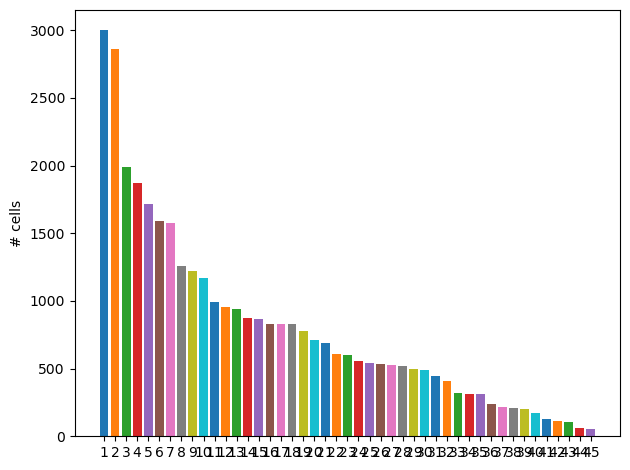

In [13]:
fig, ax = plt.subplots(1)

groups, counts = np.unique(mouseRGC.slots['ident'], return_counts=True)
for i, c in enumerate(counts):
    ax.bar(i, c)
    
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(groups)
ax.set_ylabel('# cells')

fig.tight_layout()

In [14]:
pca_mouseRGC=mouseRGC.slots['pca.rot']
pca_mouseRGC

PC1        PC2        PC3       PC4  \
aRGC1_AAACCTGAGAATCTCC-1    8.745944  -6.359495 -16.309794 -4.476088   
aRGC1_AAACCTGAGCGACGTA-1    8.494786 -11.739689 -22.955446 -5.026223   
aRGC1_AAACCTGGTAAATGAC-1    2.961551  -9.965038 -21.104850 -3.577947   
aRGC1_AAACCTGTCAAGGCTT-1   23.523083  -0.038509  -1.664531  7.299012   
aRGC1_AAACGGGAGCAGCGTA-1    2.896740   6.946160  -3.952736  0.505050   
...                              ...        ...        ...       ...   
aRGC10_TTTGTCAAGGAACTGC-1 -11.463398  -1.595074   2.215939  4.300924   
aRGC10_TTTGTCAAGTAGGTGC-1 -11.724400   0.126526   1.466790  4.111805   
aRGC10_TTTGTCACATGTAAGA-1  -0.892419 -10.564849  -0.360116  1.677696   
aRGC10_TTTGTCAGTCTAGGTT-1 -10.850538  -1.151213   2.902091  1.055440   
aRGC10_TTTGTCATCGCCTGAG-1  -6.886116   3.630588   4.704081 -8.007672   

                                PC5        PC6       PC7        PC8       PC9  \
aRGC1_AAACCTGAGAATCTCC-1   5.072967   1.785804  1.328692   1.566450  6.864920   
aRGC1_AAACCTGAGCGACGTA-1  -1.064189 -18.592966 -9.243078 -11.756335 -3.717904   
aRGC1_AAACCTGGTAAATGAC-1  -4.526950 -16.601243 -6.743233 -10.076475 -4.453045   
aRGC1_AAACCTGTCAAGGCTT-1   0.781786  -4.761108  1.671381   1.223286 -8.402879   
aRGC1_AAACGGGAGCAGCGTA-1  -3.055906  -3.810918 -0.308481   0.890120  1.142434   
...                             ...        ...       ...        ...       ...   
aRGC10_TTTGTCAAGGAACTGC-1  3.103959  -0.490052  3.057418   0.094010 -1.473914   
aRGC10_TTTGTCAAGTAGGTGC-1  4.274927  -1.583116  3.792938   1.207834 -3.084974   
aRGC10_TTTGTCACATGTAAGA-1  4.023901   0.356746  4.747637  -1.116791 -0.419076   
aRGC10_TTTGTCAGTCTAGGTT-1  3.469950   0.469451 -0.262141   2.518036  1.559788   
aRGC10_TTTGTCATCGCCTGAG-1  2.243523  -4.345655 -0.701244  -3.952020  1.508407   

                                PC10  ...      PC81      PC82      PC83  \
aRGC1_AAACCTGAGAATCTCC-1   -4.215419  ...  0.831761 -0.037156 -0.719418   
aRGC1_AAACCTGAGCGACGTA-1   19.067586  ...  0.410240 -0.154669 -6.952888   
aRGC1_AAACCTGGTAAATGAC-1   17.549366  ...  2.200324  2.809421  0.738358   
aRGC1_AAACCTGTCAAGGCTT-1   -4.073430  ...  0.262574  0.584572 -0.533935   
aRGC1_AAACGGGAGCAGCGTA-1    4.191656  ... -0.849359 -1.394044 -0.527050   
...                              ...  ...       ...       ...       ...   
aRGC10_TTTGTCAAGGAACTGC-1   0.320497  ... -0.428348  0.897826 -0.793916   
aRGC10_TTTGTCAAGTAGGTGC-1   0.374749  ...  0.497393  0.709737  0.757775   
aRGC10_TTTGTCACATGTAAGA-1  -0.557992  ... -0.596371  1.290011  0.296436   
aRGC10_TTTGTCAGTCTAGGTT-1   2.800992  ...  0.779181 -0.948467 -1.524267   
aRGC10_TTTGTCATCGCCTGAG-1  -5.868612  ...  0.806965 -0.615013  1.394130   

                               PC84      PC85      PC86      PC87      PC88  \
aRGC1_AAACCTGAGAATCTCC-1  -1.161204  0.308965  1.414349 -1.117919 -0.009773   
aRGC1_AAACCTGAGCGACGTA-1   2.227747  1.988378 -4.360306 -5.757059  4.316512   
aRGC1_AAACCTGGTAAATGAC-1  -1.986100 -2.620955 -0.550103  1.077975  1.009577   
aRGC1_AAACCTGTCAAGGCTT-1   0.649383  0.780616  0.473075 -1.413916 -0.862039   
aRGC1_AAACGGGAGCAGCGTA-1  -0.871624  1.672103  0.323732  1.629349  0.174215   
...                             ...       ...       ...       ...       ...   
aRGC10_TTTGTCAAGGAACTGC-1  0.534405 -0.683703 -0.225544 -0.288724  0.771879   
aRGC10_TTTGTCAAGTAGGTGC-1  0.911986 -0.593866 -0.221823 -1.166072  0.416831   
aRGC10_TTTGTCACATGTAAGA-1  0.598117 -1.490578 -0.667912  1.042985 -1.025638   
aRGC10_TTTGTCAGTCTAGGTT-1  0.311231 -0.208558 -0.449889 -1.828528 -0.181265   
aRGC10_TTTGTCATCGCCTGAG-1  1.474324  0.554037 -0.173119  0.512542 -0.056997   

                               PC89      PC90  
aRGC1_AAACCTGAGAATCTCC-1  -0.648225  0.650648  
aRGC1_AAACCTGAGCGACGTA-1   1.596782 -1.922258  
aRGC1_AAACCTGGTAAATGAC-1  -2.574030  1.893105  
aRGC1_AAACCTGTCAAGGCTT-1   0.151566 -0.898702  
aRGC1_AAACGGGAGCAGCGTA-1  -1.075537  0.018037  
...                             ...       ...  
aRGC10_TT

In [15]:
phate_op = phate.PHATE(n_jobs=-1)
data_phate = phate_op.fit_transform(pca_mouseRGC)

Calculating PHATE...
  Running PHATE on 35699 observations and 90 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 52.61 seconds.
    Calculating affinities...
    Calculated affinities in 2.69 seconds.
  Calculated graph and diffusion operator in 55.35 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.69 seconds.
    Calculating KMeans...
    Calculated KMeans in 8.03 seconds.
  Calculated landmark operator in 11.53 seconds.
  Calculating optimal t...
    Automatically selected t = 54
  Calculated optimal t in 5.56 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.05 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.48 seconds.
Calculated PHATE in 76.01 seconds.


### Phate plot by ident label

/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

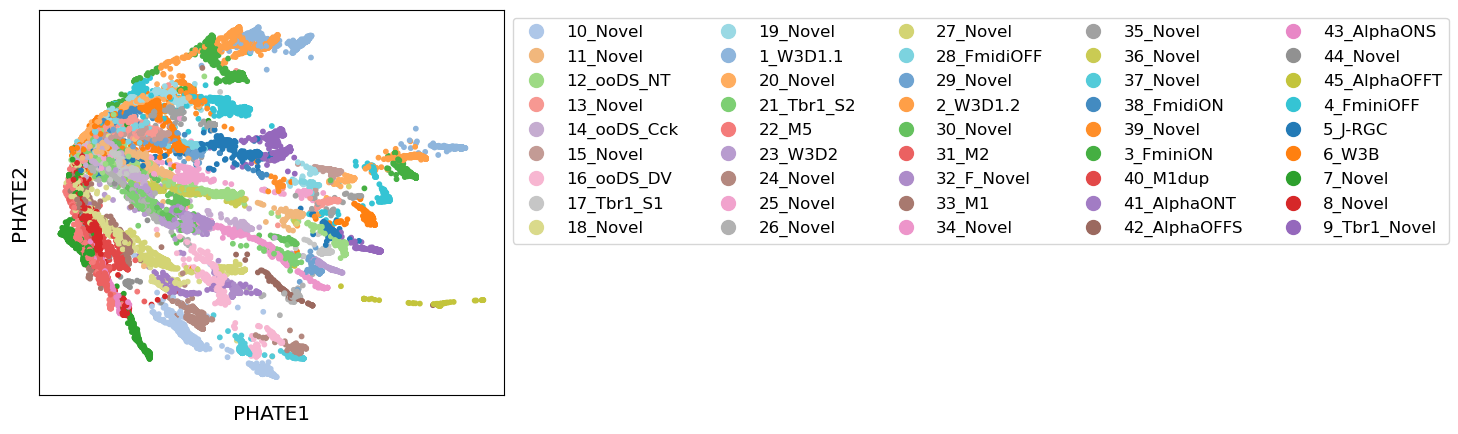

In [16]:
scprep.plot.scatter2d(data_phate, c=mouseRGC_types.new_types,
                      legend_anchor=(1,1), figsize=(6,5), s=10, label_prefix='PHATE', ticks=False)

In [17]:
# beta is the amount of smoothing to do for density estimation
# knn is the number of neighbors used to set the kernel bandwidth
meld_op = meld.MELD(beta=67, knn=7)
sample_densities = meld_op.fit_transform(pca_mouseRGC, sample_labels=mouseRGC_types.new_types)

Building graph on 35699 samples and 90 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 119.85 seconds.
  Calculating affinities...
  Calculated affinities in 3.00 seconds.
Calculated graph and diffusion operator in 123.36 seconds.


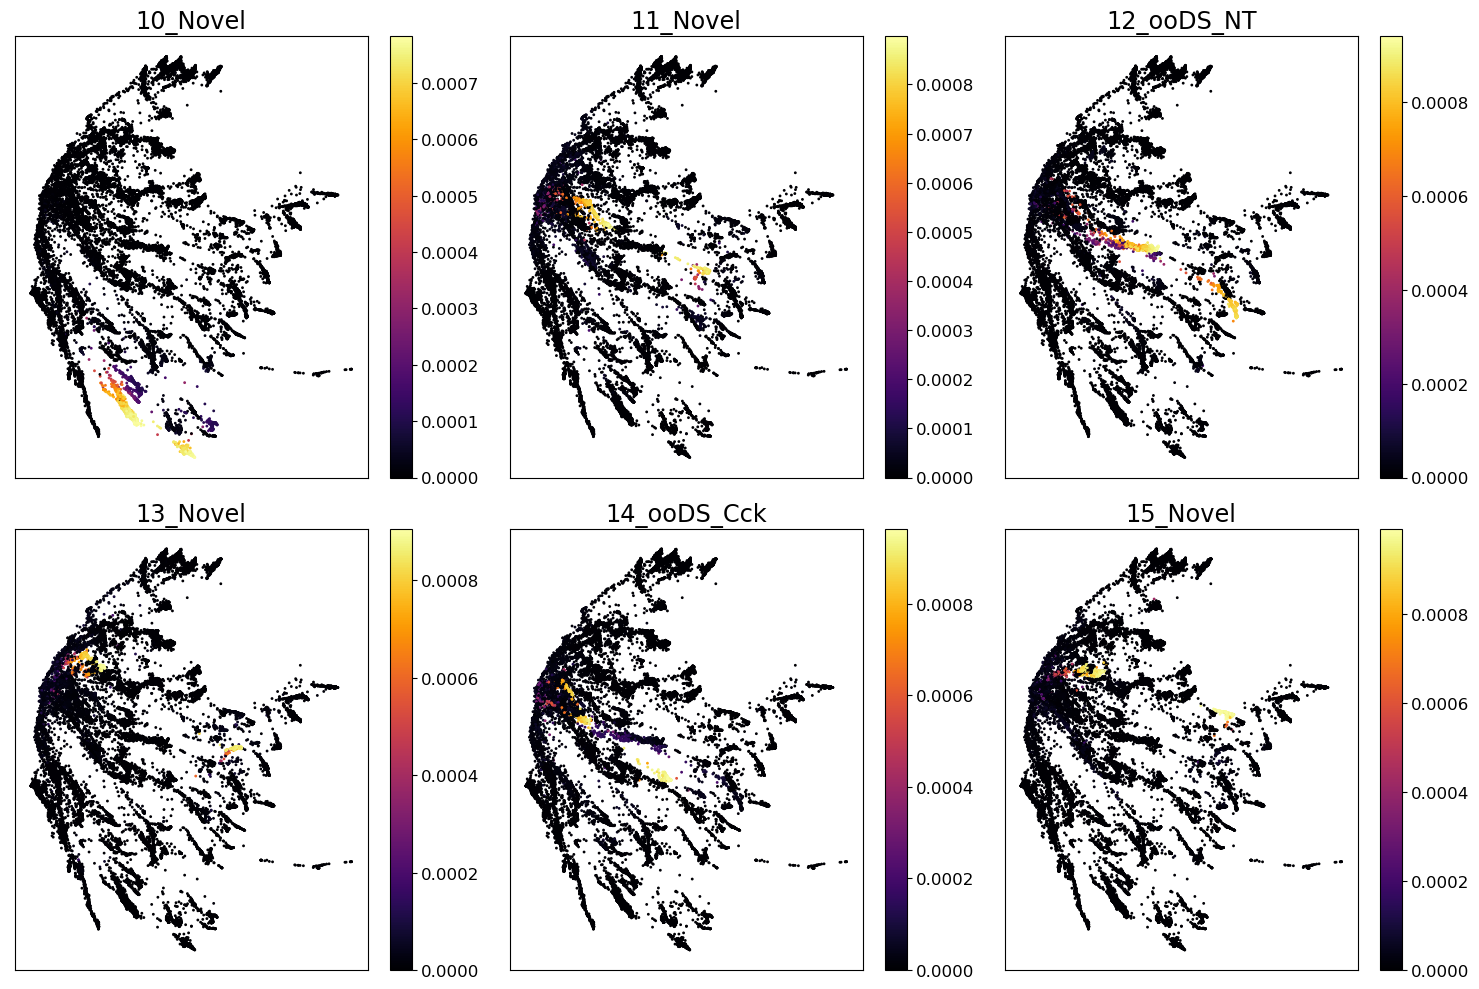

In [18]:
fig, axes = plt.subplots(2,3, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):
    density = sample_densities.iloc[:,i]
    scprep.plot.scatter2d(data_phate, c=density,
                          title=density.name,
                          vmin=0, 
                          ticks=False, ax=ax)
    
fig.tight_layout()

In [20]:
def sync_gene_names(df, orthos):
    pd.options.mode.chained_assignment = None 
    count=0
    for i in df.gene:
        try:
            ind=orthos.loc[orthos['Gene name'] == i].index[0]
            df.gene[count]=orthos['Mouse gene name'][ind]
            count+=1
        except:
            count+=1
            continue
            

# Read in macaque peripheral Rdata

In [21]:
robjects.r['load']("/Users/justinkaufman/Psych_196B_Research/MacaqueRGCObject/RGC_analysis_periphery_180629.Rdata")

<rpy2.robjects.vectors.StrVector object at 0x5640a3440> [RTYPES.STRSXP]
R classes: ('character',)
['perRGC']

In [22]:
perRGC=robjects.globalenv['perRGC']

In [23]:
pca_perRGC=perRGC.slots['pca.rot']
pca_perRGC.head()

PC1        PC2        PC3       PC4  \
M1PerCD90S1_AAACCTGTCTCTGCTG-1  5.006076  -4.747816   0.460214 -1.190186   
M1PerCD90S1_AAACGGGAGTGATCGG-1 -2.250446  -1.209849   0.002132  0.702885   
M1PerCD90S1_AAACGGGCAATAGCGG-1  1.576478  10.485785 -10.318696 -2.853375   
M1PerCD90S1_AAACGGGCACGAGAGT-1  5.740340  -1.837878  -1.135696 -0.814176   
M1PerCD90S1_AAAGATGCACTGCCAG-1  5.329309  -4.141321  -3.953011 -5.559592   

                                     PC5       PC6       PC7       PC8  \
M1PerCD90S1_AAACCTGTCTCTGCTG-1 -0.740854  0.543048 -0.014019 -0.085227   
M1PerCD90S1_AAACGGGAGTGATCGG-1 -0.938112 -1.023753 -0.615205  0.184911   
M1PerCD90S1_AAACGGGCAATAGCGG-1  9.544408 -2.596284  5.397108  2.074000   
M1PerCD90S1_AAACGGGCACGAGAGT-1  3.049728 -0.759117  1.332249 -0.460859   
M1PerCD90S1_AAAGATGCACTGCCAG-1  0.467053  6.118447  1.187642 -2.051990   

                                     PC9      PC10  ...      PC81      PC82  \
M1PerCD90S1_AAACCTGTCTCTGCTG-1 -0.307906  0.591207  ... -0.750463 -0.097573   
M1PerCD90S1_AAACGGGAGTGATCGG-1  0.012429  1.192812  ...  0.071453 -0.547315   
M1PerCD90S1_AAACGGGCAATAGCGG-1  2.790835  5.387470  ... -3.259582  1.350168   
M1PerCD90S1_AAACGGGCACGAGAGT-1  0.615729 -1.125935  ...  0.038149 -0.918872   
M1PerCD90S1_AAAGATGCACTGCCAG-1  2.872528 -3.230730  ... -1.009465  0.949142   

                                    PC83      PC84      PC85      PC86  \
M1PerCD90S1_AAACCTGTCTCTGCTG-1  0.837528  2.101504 -1.453087 -1.557716   
M1PerCD90S1_AAACGGGAGTGATCGG-1  1.453057  1.435691 -0.314433 -0.364913   
M1PerCD90S1_AAACGGGCAATAGCGG-1  0.875363  2.527203  2.217478  2.809263   
M1PerCD90S1_AAACGGGCACGAGAGT-1 -0.517958  0.783845 -0.775768  0.271670   
M1PerCD90S1_AAAGATGCACTGCCAG-1  0.001750 -0.418092 -0.054548  0.087895   

                                    PC87      PC88      PC89      PC90  
M1PerCD90S1_AAACCTGTCTCTGCTG-1 -0.515973  0.408030 -0.935876 -0.440098  
M1PerCD90S1_AAACGGGAGTGATCGG-1 -0.375654 -0.274106  0.100351 -1.883931  
M1PerCD90S1_AAACGGGCAATAGCGG-1  0.670326 -0.826871  0.573374 -0.633461  
M1PerCD90S1_AAACGGGCACGAGAGT-1  0.792284 -0.201425  0.327753  0.507601  
M1PerCD90S1_AAAGATGCACTGCCAG-1  0.624669  0.067952  1.502239  1.612731  

[5 rows x 90 columns]

In [24]:
perRGC_types=pd.read_csv("/Users/justinkaufman/Psych_196B_Research/perRGC_types.csv") # have to change directory to wherever this file is located on device
perRGC_types.rename(columns={"Unnamed: 0": "seq"},inplace=True)
perRGC_types

seq      type
0      M1PerCD90S1_AAACCTGTCTCTGCTG-1    MG_OFF
1      M1PerCD90S1_AAACGGGAGTGATCGG-1    MG_OFF
2      M1PerCD90S1_AAACGGGCAATAGCGG-1   perRGC8
3      M1PerCD90S1_AAACGGGCACGAGAGT-1     MG_ON
4      M1PerCD90S1_AAAGATGCACTGCCAG-1     MG_ON
...                               ...       ...
11718  M4PerCD73S2_TTCCCAGCAGTAACGG-1  perRGC10
11719  M4PerCD73S2_TTCTACAGTTCCACGG-1  perRGC16
11720  M4PerCD73S2_TTCTCCTGTAAGGATT-1    MG_OFF
11721  M4PerCD73S2_TTGAACGCACTGTGTA-1     MG_ON
11722  M4PerCD73S2_TTGGCAAAGGGAGTAA-1    MG_OFF

[11723 rows x 2 columns]

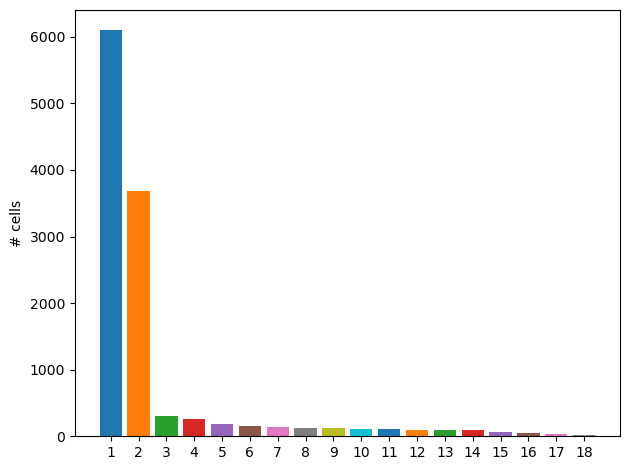

In [25]:
fig, ax = plt.subplots(1)

groups, counts = np.unique(perRGC.slots['ident'], return_counts=True)
for i, c in enumerate(counts):
    ax.bar(i, c)
    
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(groups)
ax.set_ylabel('# cells')

fig.tight_layout()

In [26]:
phate_op = phate.PHATE(n_jobs=-1)
data_phate = phate_op.fit_transform(pca_perRGC)

Calculating PHATE...
  Running PHATE on 11723 observations and 90 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 5.84 seconds.
    Calculating affinities...
    Calculated affinities in 0.94 seconds.
  Calculated graph and diffusion operator in 6.80 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.19 seconds.
    Calculating KMeans...
    Calculated KMeans in 12.62 seconds.
  Calculated landmark operator in 14.39 seconds.
  Calculating optimal t...
    Automatically selected t = 15
  Calculated optimal t in 8.62 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.78 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.72 seconds.
Calculated PHATE in 33.34 seconds.


### Phate plot by ident label

/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

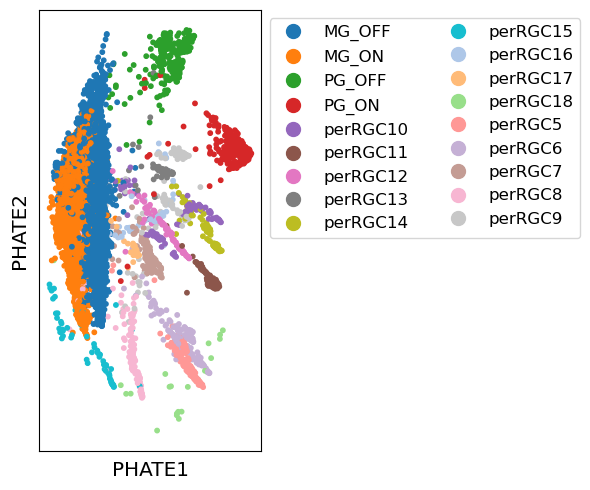

In [27]:
scprep.plot.scatter2d(data_phate, c=perRGC_types.type,
                      legend_anchor=(1,1), figsize=(6,5), s=10, label_prefix='PHATE', ticks=False)

In [28]:
# beta is the amount of smoothing to do for density estimation
# knn is the number of neighbors used to set the kernel bandwidth
meld_op = meld.MELD(beta=67, knn=7)
sample_densities = meld_op.fit_transform(pca_perRGC, sample_labels=perRGC_types.type)

Building graph on 11723 samples and 90 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 9.14 seconds.
  Calculating affinities...
  Calculated affinities in 1.41 seconds.
Calculated graph and diffusion operator in 10.76 seconds.


### Sample densities on phate plot

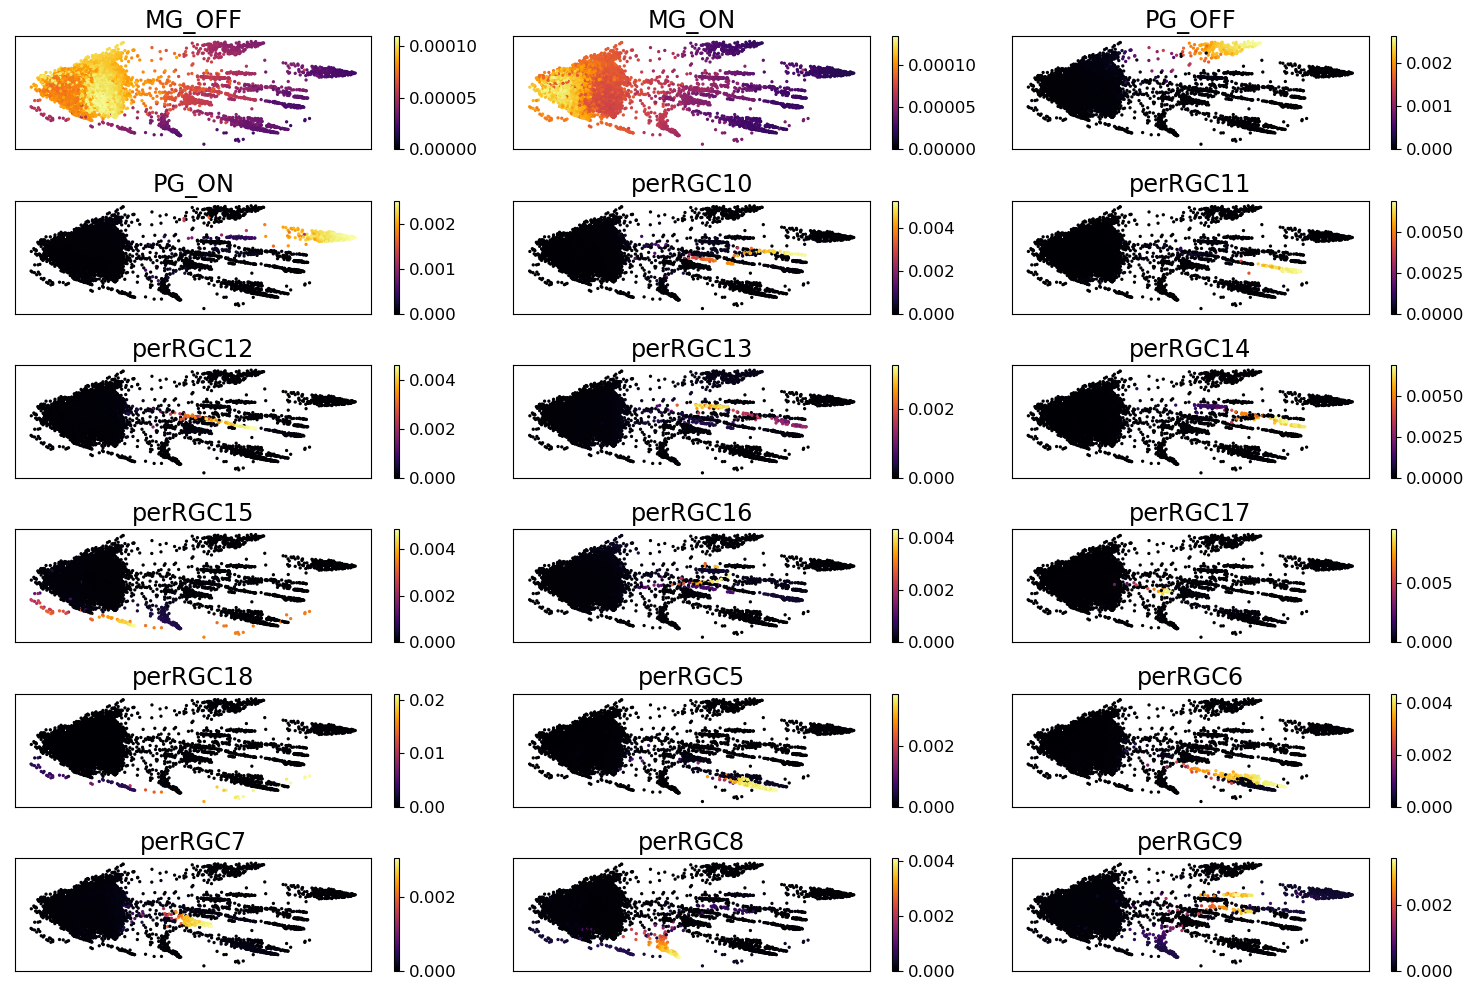

In [29]:
fig, axes = plt.subplots(6,3, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):
    density = sample_densities.iloc[:,i]
    scprep.plot.scatter2d(data_phate, c=density,
                          title=density.name,
                          vmin=0, 
                          ticks=False, ax=ax)
    
fig.tight_layout()

In [52]:
# next is relative likelihood in each condition

In [19]:
perRGC_count=pd.read_csv("/Users/justinkaufman/Psych_196B_Research/perRGC_count_data.csv") # have to change directory to wherever this file is located on device
perRGC_count.rename(columns={'Unnamed: 0':'gene'}, inplace=True)
perRGC_count=perRGC_count.loc[perRGC_count['gene'].isin(list(orthos['Gene name']))]
perRGC_count.reset_index(drop=True, inplace=True)
perRGC_count

gene  M1PerCD90S1_AAACCTGTCTCTGCTG-1  \
0      SH3BP5L                               0   
1        TFB2M                               1   
2        SMYD3                               0   
3         AKT3                               4   
4       CEP170                               1   
...        ...                             ...   
11771    MECP2                               1   
11772    UBL4A                               0   
11773    FAM3A                               1   
11774     GAB3                               0   
11775     MPP1                               0   

       M1PerCD90S1_AAACGGGAGTGATCGG-1  M1PerCD90S1_AAACGGGCAATAGCGG-1  \
0                                   0                               0   
1                                   0                               0   
2                                   0                               0   
3                                   4                               2   
4                                   2                               4   
...                               ...                             ...   
11771                               1                               1   
11772                               0                               1   
11773                               1                               0   
11774                               0                               0   
11775                               0                               0   

       M1PerCD90S1_AAACGGGCACGAGAGT-1  M1PerCD90S1_AAAGATGCACTGCCAG-1  \
0                                   0                               0   
1                                   1                               0   
2                                   0                               0   
3                                   2                               3   
4                                   1                               4   
...                               ...                             ...   
11771                               0                               1   
11772                               0                               0   
11773                               1                               0   
11774                               0                               0   
11775                               0                               0   

       M1PerCD90S1_AAAGATGCATGTAGTC-1  M1PerCD90S1_AAAGATGTCAGCTCTC-1  \
0                                   0                               0   
1                                   0                               0   
2                                   0                               2   
3                                   1                               1   
4                                   3                               0   
...                               ...                             ...   
11771                               1                               0   
11772                               1                               1   
11773                               0                               0   
11774                               0                               0   
11775                               1                               0   

       M1PerCD90S1_AAAGCAAAGCGCCTTG-1  M1PerCD90S1_AAAGCAAGTTAAGTAG-1  ...  \
0                                   1                               0  ...   
1                                   0                               0  ...   
2                                   0                               2  ...   
3                                   0                               0  ...   
4                                   2                               1  ...   
...                               ...                             ...  ...   
11771                               0                               0  ...   
11772                               2                               0  ...   
11773                               0                               0  ...  

In [30]:
sync_gene_names(perRGC_count, orthos)

In [31]:
perRGC_count

gene  M1PerCD90S1_AAACCTGTCTCTGCTG-1  \
0      Sh3bp5l                               0   
1        Tfb2m                               1   
2        Smyd3                               0   
3         Akt3                               4   
4       Cep170                               1   
...        ...                             ...   
11771    Mecp2                               1   
11772  Slc10a3                               0   
11773    Fam3a                               1   
11774     Gab3                               0   
11775     Mpp1                               0   

       M1PerCD90S1_AAACGGGAGTGATCGG-1  M1PerCD90S1_AAACGGGCAATAGCGG-1  \
0                                   0                               0   
1                                   0                               0   
2                                   0                               0   
3                                   4                               2   
4                                   2                               4   
...                               ...                             ...   
11771                               1                               1   
11772                               0                               1   
11773                               1                               0   
11774                               0                               0   
11775                               0                               0   

       M1PerCD90S1_AAACGGGCACGAGAGT-1  M1PerCD90S1_AAAGATGCACTGCCAG-1  \
0                                   0                               0   
1                                   1                               0   
2                                   0                               0   
3                                   2                               3   
4                                   1                               4   
...                               ...                             ...   
11771                               0                               1   
11772                               0                               0   
11773                               1                               0   
11774                               0                               0   
11775                               0                               0   

       M1PerCD90S1_AAAGATGCATGTAGTC-1  M1PerCD90S1_AAAGATGTCAGCTCTC-1  \
0                                   0                               0   
1                                   0                               0   
2                                   0                               2   
3                                   1                               1   
4                                   3                               0   
...                               ...                             ...   
11771                               1                               0   
11772                               1                               1   
11773                               0                               0   
11774                               0                               0   
11775                               1                               0   

       M1PerCD90S1_AAAGCAAAGCGCCTTG-1  M1PerCD90S1_AAAGCAAGTTAAGTAG-1  ...  \
0                                   1                               0  ...   
1                                   0                               0  ...   
2                                   0                               2  ...   
3                                   0                               0  ...   
4                                   2                               1  ...   
...                               ...                             ...  ...   
11771                               0                               0  ...   
11772                               2                               0  ...   
11773                               0                               0  ...  

# Merge the per and mouse datasets

In [32]:
# merged_macaque_count=pd.merge(foveaRGC_count, perRGC_count, how="outer", on=["gene"])

In [33]:
merged_count=pd.merge(mouseRGC_count, perRGC_count, how="outer", on=["gene"])
merged_count.fillna(0,inplace=True)
merged_count

gene  aRGC1_AAACCTGAGAATCTCC-1  aRGC1_AAACCTGAGCGACGTA-1  \
0       Sox17                       0.0                       0.0   
1      Mrpl15                       0.0                       0.0   
2      Lypla1                       1.0                       0.0   
3       Tcea1                       3.0                       0.0   
4       Rgs20                       0.0                       0.0   
...       ...                       ...                       ...   
13116    Mrln                       0.0                       0.0   
13117   Frat1                       0.0                       0.0   
13118    Slf2                       0.0                       0.0   
13119  Itprip                       0.0                       0.0   
13120  Ints6l                       0.0                       0.0   

       aRGC1_AAACCTGGTAAATGAC-1  aRGC1_AAACCTGTCAAGGCTT-1  \
0                           0.0                       0.0   
1                           0.0                       1.0   
2                           0.0                       0.0   
3                           0.0                       0.0   
4                           0.0                       0.0   
...                         ...                       ...   
13116                       0.0                       0.0   
13117                       0.0                       0.0   
13118                       0.0                       0.0   
13119                       0.0                       0.0   
13120                       0.0                       0.0   

       aRGC1_AAACGGGAGCAGCGTA-1  aRGC1_AAACGGGCAATCTACG-1  \
0                           0.0                       0.0   
1                           2.0                       2.0   
2                           1.0                       1.0   
3                           1.0                       1.0   
4                           1.0                       0.0   
...                         ...                       ...   
13116                       0.0                       0.0   
13117                       0.0                       0.0   
13118                       0.0                       0.0   
13119                       0.0                       0.0   
13120                       0.0                       0.0   

       aRGC1_AAACGGGCACCACCAG-1  aRGC1_AAACGGGCAGCGTTCG-1  \
0                           0.0                       0.0   
1                           1.0                       1.0   
2                           0.0                       2.0   
3                           0.0                       0.0   
4                           0.0                       0.0   
...                         ...                       ...   
13116                       0.0                       0.0   
13117                       0.0                       0.0   
13118                       0.0                       0.0   
13119                       0.0                       0.0   
13120                       0.0                       0.0   

       aRGC1_AAACGGGCAGGTTTCA-1  ...  M4PerCD73S2_TGGTTAGTCACCCTCA-1  \
0                           0.0  ...                             0.0   
1                           0.0  ...                             0.0   
2                           1.0  ...                             0.0   
3                           0.0  ...                             1.0   
4                           2.0  ...                             0.0   
...                         ...  ...                             ...   
13116                       0.0  ...                             0.0   
13117                       0.0  ...                             0.0   
13118                       0.0  ...                             1.0   
13119                       0.0  ...                             0.0   
13120                       0.0  ...                             0.0   

       M4PerCD73S2_TGTCCCATCGTCCGTT-1  M4PerCD73S2_TTAACTCTCGCGTTTC-1  \
0                                 0.0      

In [34]:
merged_count_test=merged_count.set_index('gene')
merged_count_test=merged_count_test.T
merged_count_test

gene                            Sox17  Mrpl15  Lypla1  Tcea1  Rgs20  Atp6v1h  \
aRGC1_AAACCTGAGAATCTCC-1          0.0     0.0     1.0    3.0    0.0      1.0   
aRGC1_AAACCTGAGCGACGTA-1          0.0     0.0     0.0    0.0    0.0      2.0   
aRGC1_AAACCTGGTAAATGAC-1          0.0     0.0     0.0    0.0    0.0      0.0   
aRGC1_AAACCTGTCAAGGCTT-1          0.0     1.0     0.0    0.0    0.0      3.0   
aRGC1_AAACGGGAGCAGCGTA-1          0.0     2.0     1.0    1.0    1.0      3.0   
...                               ...     ...     ...    ...    ...      ...   
M4PerCD73S2_TTCCCAGCAGTAACGG-1    0.0     2.0     1.0    4.0    0.0      2.0   
M4PerCD73S2_TTCTACAGTTCCACGG-1    0.0     1.0     1.0    4.0    1.0      3.0   
M4PerCD73S2_TTCTCCTGTAAGGATT-1    0.0     1.0     0.0    1.0    0.0      1.0   
M4PerCD73S2_TTGAACGCACTGTGTA-1    0.0     3.0     1.0    0.0    0.0      5.0   
M4PerCD73S2_TTGGCAAAGGGAGTAA-1    0.0     2.0     2.0    0.0    0.0      4.0   

gene                            Oprk1  Npbwr1  Rb1cc1  St18  ...  Fam91a1  \
aRGC1_AAACCTGAGAATCTCC-1          0.0     0.0     1.0   0.0  ...      0.0   
aRGC1_AAACCTGAGCGACGTA-1          0.0     0.0     0.0   0.0  ...      0.0   
aRGC1_AAACCTGGTAAATGAC-1          0.0     0.0     0.0   0.0  ...      0.0   
aRGC1_AAACCTGTCAAGGCTT-1          0.0     0.0     2.0   0.0  ...      0.0   
aRGC1_AAACGGGAGCAGCGTA-1          0.0     0.0     4.0   0.0  ...      0.0   
...                               ...     ...     ...   ...  ...      ...   
M4PerCD73S2_TTCCCAGCAGTAACGG-1    0.0     0.0     4.0   0.0  ...      0.0   
M4PerCD73S2_TTCTACAGTTCCACGG-1    0.0     0.0     3.0   0.0  ...      0.0   
M4PerCD73S2_TTCTCCTGTAAGGATT-1    0.0     0.0     0.0   0.0  ...      1.0   
M4PerCD73S2_TTGAACGCACTGTGTA-1    0.0     0.0     2.0   0.0  ...      1.0   
M4PerCD73S2_TTGGCAAAGGGAGTAA-1    0.0     0.0     0.0   0.0  ...      0.0   

gene                            Tmem249  Vps28  C030006K11Rik  Frmpd2  Mrln  \
aRGC1_AAACCTGAGAATCTCC-1            0.0    0.0            0.0     0.0   0.0   
aRGC1_AAACCTGAGCGACGTA-1            0.0    0.0            0.0     0.0   0.0   
aRGC1_AAACCTGGTAAATGAC-1            0.0    0.0            0.0     0.0   0.0   
aRGC1_AAACCTGTCAAGGCTT-1            0.0    0.0            0.0     0.0   0.0   
aRGC1_AAACGGGAGCAGCGTA-1            0.0    0.0            0.0     0.0   0.0   
...                                 ...    ...            ...     ...   ...   
M4PerCD73S2_TTCCCAGCAGTAACGG-1      0.0   12.0            3.0     0.0   0.0   
M4PerCD73S2_TTCTACAGTTCCACGG-1      0.0    5.0            0.0     0.0   0.0   
M4PerCD73S2_TTCTCCTGTAAGGATT-1      0.0    1.0            0.0     0.0   0.0   
M4PerCD73S2_TTGAACGCACTGTGTA-1      0.0    7.0            0.0     0.0   0.0   
M4PerCD73S2_TTGGCAAAGGGAGTAA-1      0.0    7.0            0.0     0.0   0.0   

gene                            Frat1  Slf2  Itprip  Ints6l  
aRGC1_AAACCTGAGAATCTCC-1          0.0   0.0     0.0     0.0  
aRGC1_AAACCTGAGCGACGTA-1          0.0   0.0     0.0     0.0  
aRGC1_AAACCTGGTAAATGAC-1          0.0   0.0     0.0     0.0  
aRGC1_AAACCTGTCAAGGCTT-1          0.0   0.0     0.0     0.0  
aRGC1_AAACGGGAGCAGCGTA-1          0.0   0.0     0.0     0.0  
...                               ...   ...     ...     ...  
M4PerCD73S2_TTCCCAGCAGTAACGG-1    0.0   0.0     0.0     0.0  
M4PerCD73S2_TTCTACAGTTCCACGG-1    0.0   0.0     0.0     0.0  
M4PerCD73S2_TTCTCCTGTAAGGATT-1    0.0   0.0     0.0     0.0  
M4PerCD73S2_TTGAACGCACTGTGTA-1    0.0   1.0     0.0     0.0  
M4PerCD73S2_TTGGCAAAGGGAGTAA-1    0.0   0.0     0.0     0.0  

[47422 rows x 13121 columns]

In [117]:
merged_count_norm = StandardScaler().fit_transform(merged_count_test)

In [118]:
pca = PCA(n_components=90)
principalComponents = pca.fit_transform(merged_count_norm)

In [119]:
principalDf = pd.DataFrame(principalComponents)

In [120]:
principalDf

0          1          2          3          4          5   \
0       8.269860  -8.911668  12.020370  13.763994  -0.845186   8.450451   
1     -25.187963  -9.359296  10.868584   6.068020   2.410562  11.804068   
2     -24.974199 -10.798178   6.818108   6.281821   2.209406   7.929352   
3      33.206116  -1.826560  31.959834   7.105253  11.112575  -1.910577   
4      59.124355  -8.478407  -0.471730  20.602058 -13.472478  -9.041482   
...          ...        ...        ...        ...        ...        ...   
47417  16.143711  57.852707 -12.969851  20.313373  11.629791   9.874421   
47418  36.930827  81.265985 -20.852709  29.464094  11.009226  21.635168   
47419 -25.734484  22.180737   2.868608  -3.097334   0.651264   2.075846   
47420   4.957025  60.149345  10.818581 -11.467043  -5.778018  -1.525475   
47421  -5.590773  41.664449 -13.985722  -0.704732   5.581807  -1.599468   

              6          7         8         9   ...        80        81  \
0      10.185088  -9.119981  8.674211  5.721089  ... -0.106196 -1.337784   
1       8.112035  -1.381259  2.587684  2.459499  ...  0.876263 -0.900019   
2       9.310149  -1.950584  0.759423  2.286807  ...  0.175178  0.464972   
3       6.462248  -0.343577  3.668173 -2.273592  ... -2.638350 -1.005760   
4      12.136214  -5.274290 -6.794235  1.735828  ... -0.261169 -0.222146   
...          ...        ...       ...       ...  ...       ...       ...   
47417 -11.070912   2.885717  5.854490  0.866500  ... -1.587674 -1.843431   
47418 -27.648938   5.517190 -0.324070  3.521058  ...  1.772046  3.796219   
47419  -1.262073  -4.990648 -1.313090  1.250429  ...  1.241632 -2.058609   
47420   3.325716  -5.167326  0.013887  7.999363  ... -0.134209 -2.766382   
47421  -1.444333 -11.890619 -1.952888  1.788945  ...  2.555208  2.502811   

             82        83        84        85        86        87         88  \
0     -0.356282 -0.863413 -1.615136 -0.351208  0.934738 -0.184728  -0.148617   
1     -0.689122  0.580133 -0.203632 -0.203965 -0.023084  1.016533  -1.884851   
2     -1.819219 -0.474072  2.579829 -1.507524 -0.055219  0.763857  -3.279296   
3      1.376947 -0.170246 -1.343470 -1.046746  1.725229 -1.616252  -3.214293   
4     -1.822277 -0.225295  1.905716  1.303179  0.713664 -2.655762  -0.088070   
...         ...       ...       ...       ...       ...       ...        ...   
47417 -2.959950  3.098749 -0.846959 -8.768508 -0.618203 -6.636385  -2.978628   
47418 -6.413149 -4.083032 -1.037719  2.807186  6.076995 -8.627210  10.044910   
47419  0.917225 -0.709747  0.990423  0.423998  0.840139 -1.821768   1.721171   
47420  0.296764  0.046097  5.016755 -1.342731 -3.769649  2.549960  -5.494500   
47421 -1.427035  0.006646  0.760135 -0.917555 -5.548185 -7.760887  -1.082667   

             89  
0     -0.117921  
1     -0.576653  
2      0.256273  
3     -2.664247  
4     -0.018362  
...         ...  
47417 -0.755932  
47418  0.243729  
47419 -2.253623  
47420  1.827214  
47421 -1.817814  

[47422 rows x 90 columns]

In [207]:
phate_op = phate.PHATE(n_jobs=-1)
data_phate = phate_op.fit_transform(principalDf)

Calculating PHATE...
  Running PHATE on 47422 observations and 90 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 56.49 seconds.
    Calculating affinities...
    Calculated affinities in 0.52 seconds.
  Calculated graph and diffusion operator in 57.05 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.25 seconds.
    Calculating KMeans...
    Calculated KMeans in 13.66 seconds.
  Calculated landmark operator in 19.07 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 11.35 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.88 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.07 seconds.
Calculated PHATE in 91.46 seconds.


In [122]:
ident=[]
for i in merged_count_test.index:
    try:
        ind=mouseRGC_types.loc[mouseRGC_types['seq'] == i].index[0]
        ident.append(mouseRGC_types.new_types[ind])
    except:
#         try:
#             ind=foveaRGC_types.loc[foveaRGC_types['seq'] == i].index[0]
#             ident.append(foveaRGC_types.per_type[ind])
#         except:
        try:
            ind=perRGC_types.loc[perRGC_types['seq'] == i].index[0]
            ident.append(perRGC_types.type[ind])
        except:
            continue

In [123]:
sample=[]
for i in merged_count_test.index:
    try:
        samp=mouseRGC_types.loc[mouseRGC_types['seq'] == i].index[0]
        sample.append('mouse')
    except:
#         try:
#             samp=foveaRGC_types.loc[foveaRGC_types['seq'] == i].index[0]
#             sample.append('fovea')
#         except:
        try:
            samp=perRGC_types.loc[perRGC_types['seq'] == i].index[0]
            sample.append('peripheral')
        except:
            continue

### Coloring Phate Plot by Sample Labels

/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

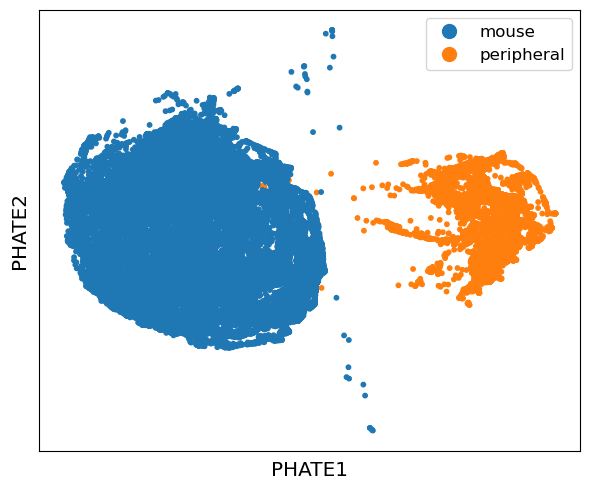

In [124]:
scprep.plot.scatter2d(data_phate, c= sample,
                      legend_anchor=(1,1), figsize=(6,5), s=10, label_prefix='PHATE', ticks=False)

### Coloring Phate Plot By Ident Labels

/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:99: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.

/opt/miniconda3/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

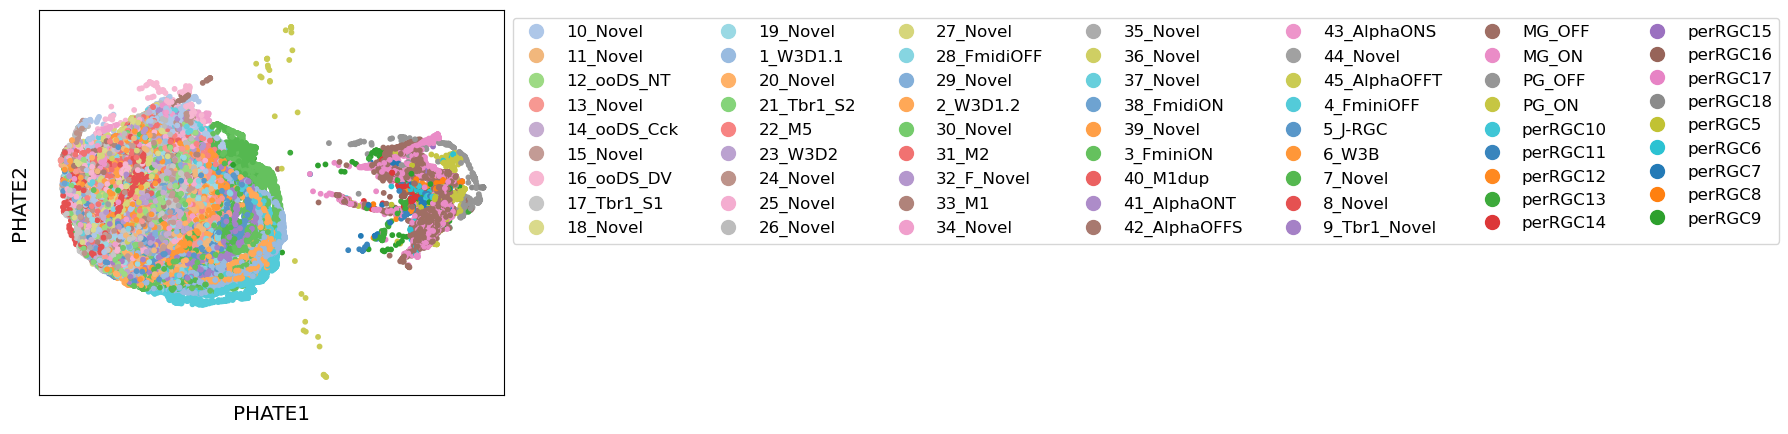

In [125]:
scprep.plot.scatter2d(data_phate, c= ident,
                      legend_anchor=(1,1), figsize=(6,5), s=10, label_prefix='PHATE', ticks=False)

In [203]:
# beta is the amount of smoothing to do for density estimation
# knn is the number of neighbors used to set the kernel bandwidth
meld_op = meld.MELD(beta=67, knn=10)
sample_densities = meld_op.fit_transform(principalDf, sample_labels=pd.DataFrame(ident))

Building graph on 47422 samples and 90 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 185.01 seconds.
  Calculating affinities...
  Calculated affinities in 0.82 seconds.
Calculated graph and diffusion operator in 186.95 seconds.


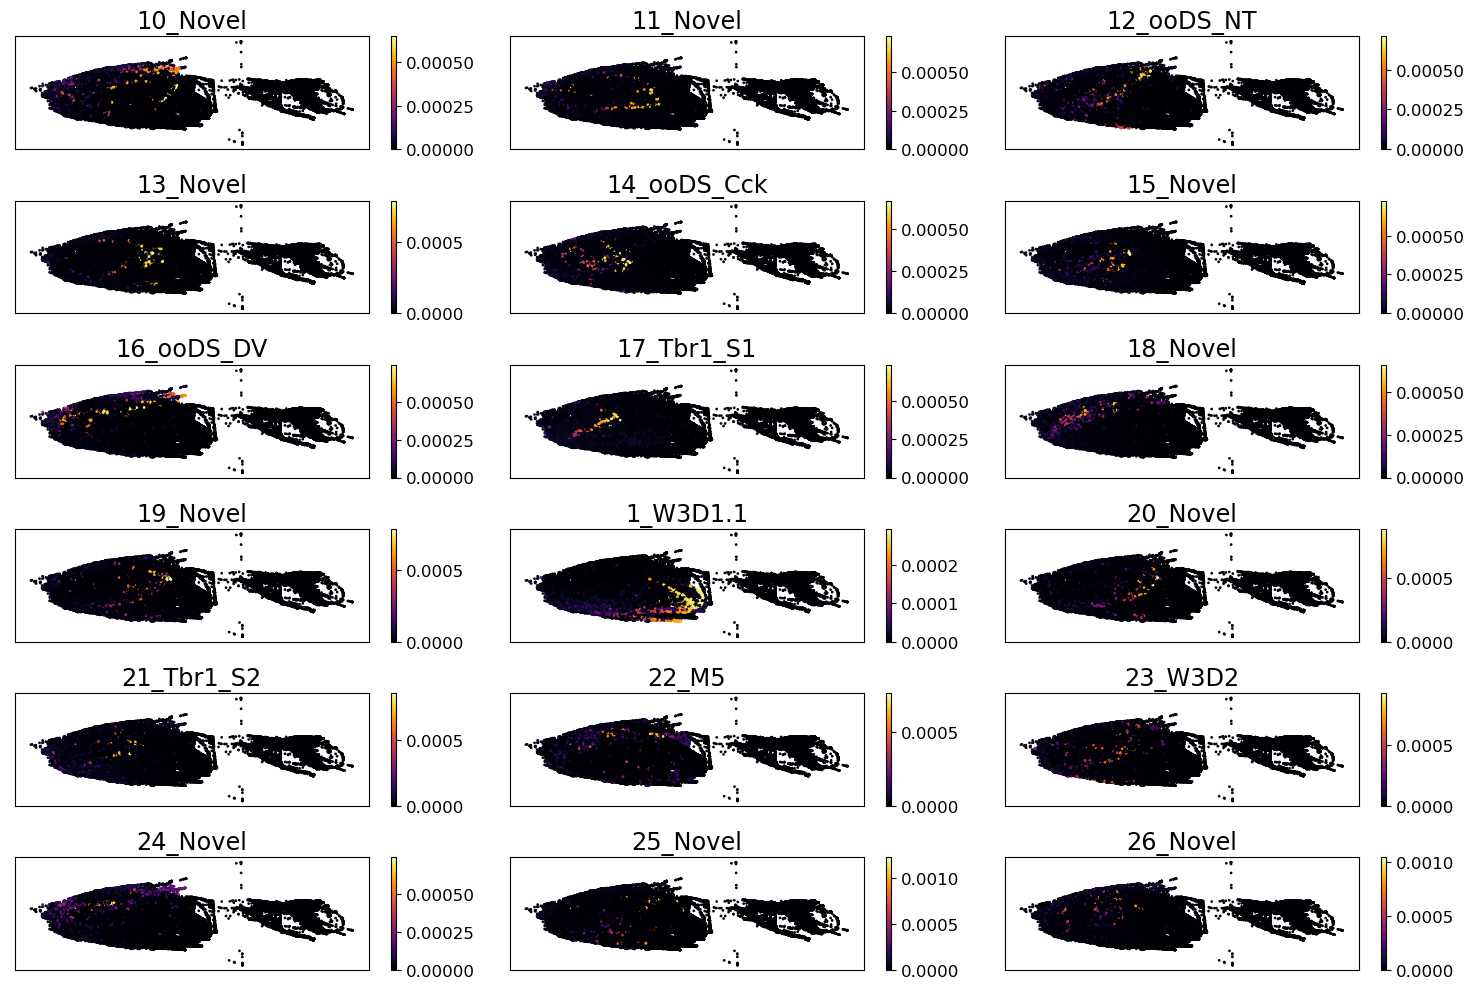

In [208]:
fig, axes = plt.subplots(6,3, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):
    density = sample_densities.iloc[:,i]
    scprep.plot.scatter2d(data_phate, c=density,
                          title=density.name,
                          vmin=0, 
                          ticks=False, ax=ax)
    
fig.tight_layout()

In [209]:
# beta is the amount of smoothing to do for density estimation
# knn is the number of neighbors used to set the kernel bandwidth
meld_op = meld.MELD(beta=67, knn=10)
sample_densities = meld_op.fit_transform(principalDf, sample_labels=pd.DataFrame(sample))

Building graph on 47422 samples and 90 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 198.27 seconds.
  Calculating affinities...
  Calculated affinities in 0.79 seconds.
Calculated graph and diffusion operator in 199.99 seconds.


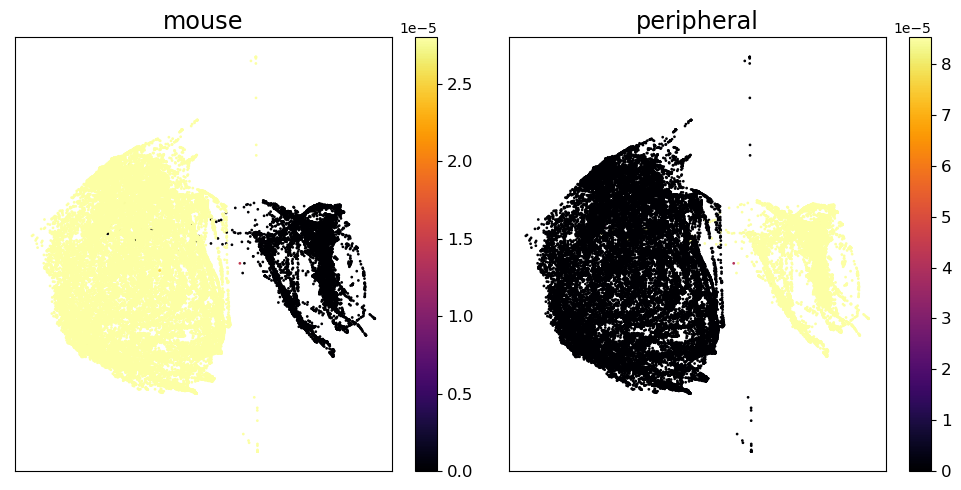

In [213]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

for i, ax in enumerate(axes.flatten()):
    density = sample_densities.iloc[:,i]
    scprep.plot.scatter2d(data_phate, c=density,
                          title=density.name,
                          vmin=0, 
                          ticks=False, ax=ax)
    
fig.tight_layout()

# SAMap

In [186]:
sams = {'mouse':sam1,'mac':sam2}

In [187]:
sm = SAMAP(sams, f_maps = '/maps/')

FileExistsError: BLAST mapping tables with the input IDs (leiden_clusters and mac) not found in the specified path.

In [188]:
per_count

gene                            Sh3bp5l  Tfb2m  Smyd3  Akt3  Cep170  Pld5  \
M1PerCD90S1_AAACCTGTCTCTGCTG-1      0.0    1.0    0.0   4.0     1.0   0.0   
M1PerCD90S1_AAACGGGAGTGATCGG-1      0.0    0.0    0.0   4.0     2.0   0.0   
M1PerCD90S1_AAACGGGCAATAGCGG-1      0.0    0.0    0.0   2.0     4.0   0.0   
M1PerCD90S1_AAACGGGCACGAGAGT-1      0.0    1.0    0.0   2.0     1.0   0.0   
M1PerCD90S1_AAAGATGCACTGCCAG-1      0.0    0.0    0.0   3.0     4.0   0.0   
...                                 ...    ...    ...   ...     ...   ...   
M4PerCD73S2_TTCCCAGCAGTAACGG-1      0.0    0.0    1.0   1.0     2.0   0.0   
M4PerCD73S2_TTCTACAGTTCCACGG-1      1.0    0.0    0.0   1.0     8.0   0.0   
M4PerCD73S2_TTCTCCTGTAAGGATT-1      0.0    0.0    0.0   1.0     1.0   0.0   
M4PerCD73S2_TTGAACGCACTGTGTA-1      0.0    0.0    0.0   4.0     3.0   0.0   
M4PerCD73S2_TTGGCAAAGGGAGTAA-1      0.0    0.0    0.0   0.0     0.0   0.0   

gene                            Opn3  Fh1  Rgs7  Grem2  ...  Arhgap4  Naa10  \
M1PerCD90S1_AAACCTGTCTCTGCTG-1   0.0  1.0   0.0    0.0  ...      0.0    1.0   
M1PerCD90S1_AAACGGGAGTGATCGG-1   0.0  0.0   0.0    0.0  ...      0.0    0.0   
M1PerCD90S1_AAACGGGCAATAGCGG-1   0.0  0.0   1.0    0.0  ...      0.0    3.0   
M1PerCD90S1_AAACGGGCACGAGAGT-1   0.0  0.0   0.0    0.0  ...      0.0    0.0   
M1PerCD90S1_AAAGATGCACTGCCAG-1   0.0  1.0   1.0    0.0  ...      0.0    1.0   
...                              ...  ...   ...    ...  ...      ...    ...   
M4PerCD73S2_TTCCCAGCAGTAACGG-1   0.0  2.0   5.0    0.0  ...      0.0    1.0   
M4PerCD73S2_TTCTACAGTTCCACGG-1   1.0  0.0   1.0    0.0  ...      0.0    2.0   
M4PerCD73S2_TTCTCCTGTAAGGATT-1   0.0  1.0   0.0    1.0  ...      1.0    0.0   
M4PerCD73S2_TTGAACGCACTGTGTA-1   0.0  1.0   0.0    2.0  ...      0.0    0.0   
M4PerCD73S2_TTGGCAAAGGGAGTAA-1   0.0  0.0   0.0    0.0  ...      0.0    0.0   

gene                            Renbp  Hcfc1  Irak1  Mecp2  Slc10a3  Fam3a  \
M1PerCD90S1_AAACCTGTCTCTGCTG-1    0.0    0.0    0.0    1.0      0.0    1.0   
M1PerCD90S1_AAACGGGAGTGATCGG-1    0.0    0.0    0.0    1.0      0.0    1.0   
M1PerCD90S1_AAACGGGCAATAGCGG-1    0.0    2.0    0.0    1.0      1.0    0.0   
M1PerCD90S1_AAACGGGCACGAGAGT-1    0.0    0.0    0.0    0.0      0.0    1.0   
M1PerCD90S1_AAAGATGCACTGCCAG-1    0.0    1.0    0.0    1.0      0.0    0.0   
...                               ...    ...    ...    ...      ...    ...   
M4PerCD73S2_TTCCCAGCAGTAACGG-1    0.0    0.0    0.0    0.0      2.0    1.0   
M4PerCD73S2_TTCTACAGTTCCACGG-1    0.0    1.0    0.0    4.0      8.0    1.0   
M4PerCD73S2_TTCTCCTGTAAGGATT-1    0.0    0.0    0.0    1.0      0.0    0.0   
M4PerCD73S2_TTGAACGCACTGTGTA-1    0.0    0.0    0.0    0.0      3.0    1.0   
M4PerCD73S2_TTGGCAAAGGGAGTAA-1    0.0    0.0    0.0    0.0      0.0    0.0   

gene                            Gab3  Mpp1  
M1PerCD90S1_AAACCTGTCTCTGCTG-1   0.0   0.0  
M1PerCD90S1_AAACGGGAGTGATCGG-1   0.0   0.0  
M1PerCD90S1_AAACGGGCAATAGCGG-1   0.0   0.0  
M1PerCD90S1_AAACGGGCACGAGAGT-1   0.0   0.0  
M1PerCD90S1_AAAGATGCACTGCCAG-1   0.0   0.0  
...                              ...   ...  
M4PerCD73S2_TTCCCAGCAGTAACGG-1   0.0   3.0  
M4PerCD73S2_TTCTACAGTTCCACGG-1   0.0   0.0  
M4PerCD73S2_TTCTCCTGTAAGGATT-1   0.0   1.0  
M4PerCD73S2_TTGAACGCACTGTGTA-1   0.0   2.0  
M4PerCD73S2_TTGGCAAAGGGAGTAA-1   0.0   2.0  

[11723 rows x 11776 columns]

# Liger 

In [307]:
import pyliger
import anndata

In [73]:
from anndata import read_h5ad
ctrl_dge = read_h5ad('/Users/justinkaufman/Pyliger/multi_scRNA_data/pbmc_ctrl.h5ad', backed='r+')
stim_dge = read_h5ad('/Users/justinkaufman/Pyliger/multi_scRNA_data/pbmc_stim.h5ad', backed='r+')

In [114]:
ctrl_dge.X, ctrl_dge.var, ctrl_dge.obs

<HDF5 sparse dataset: format 'csr', shape (3000, 35635), type '<f4'>

In [163]:
stim_dge.uns

OverloadedDict, wrapping:
	{'data_type': 'Gene Expression', 'sample_name': 'stim'}
With overloaded keys:
	['neighbors'].

In [166]:
mouse_adata.uns

OverloadedDict, wrapping:
	{'data_type': 'Gene Expression', 'sample_name': 'mouse'}
With overloaded keys:
	['neighbors'].

In [165]:
obs = pd.DataFrame()
obs['barcodes'] = mouseRGC_count.columns[1:]
obs.set_index(['barcodes'],inplace=True)
var_names = mouseRGC_count.gene
var = pd.DataFrame(index=var_names)
# # the data matrix 
X = mouseRGC_count.drop(columns=['gene']).T.values
mouse_adata = anndata.AnnData(X, obs=obs, var=var, uns={'data_type':'Gene Expression', 'sample_name':'mouse'},dtype='int32')


obs = pd.DataFrame()
obs['barcodes'] = perRGC_count.columns[1:]
obs.set_index(['barcodes'],inplace=True)
var_names = perRGC_count.gene
var = pd.DataFrame(index=var_names)
X = perRGC_count.drop(columns=['gene']).T.values
mac_adata = anndata.AnnData(X, obs=obs, var=var, uns={'data_type':'Gene Expression', 'sample_name':'macaque'}, dtype='int32')

In [167]:
adata_list = [mouse_adata, mac_adata]
ifnb_liger = pyliger.create_liger(adata_list)

Removing 692 genes not expressing in mouse.
Removing 791 genes not expressing in macaque.


In [168]:
pyliger.normalize(ifnb_liger)
pyliger.select_genes(ifnb_liger)
pyliger.scale_not_center(ifnb_liger)

In [169]:
pyliger.optimize_ALS(ifnb_liger, k = 40)

100%|███████████████████████████████████████████| 30/30 [04:29<00:00,  9.00s/it]


In [170]:
pyliger.quantile_norm(ifnb_liger)

In [171]:
pyliger.leiden_cluster(ifnb_liger, resolution=0.25)

In [172]:
pyliger.run_umap(ifnb_liger, distance = 'cosine', n_neighbors = 30, min_dist = 0.3)

<IPython.core.display.Javascript object>


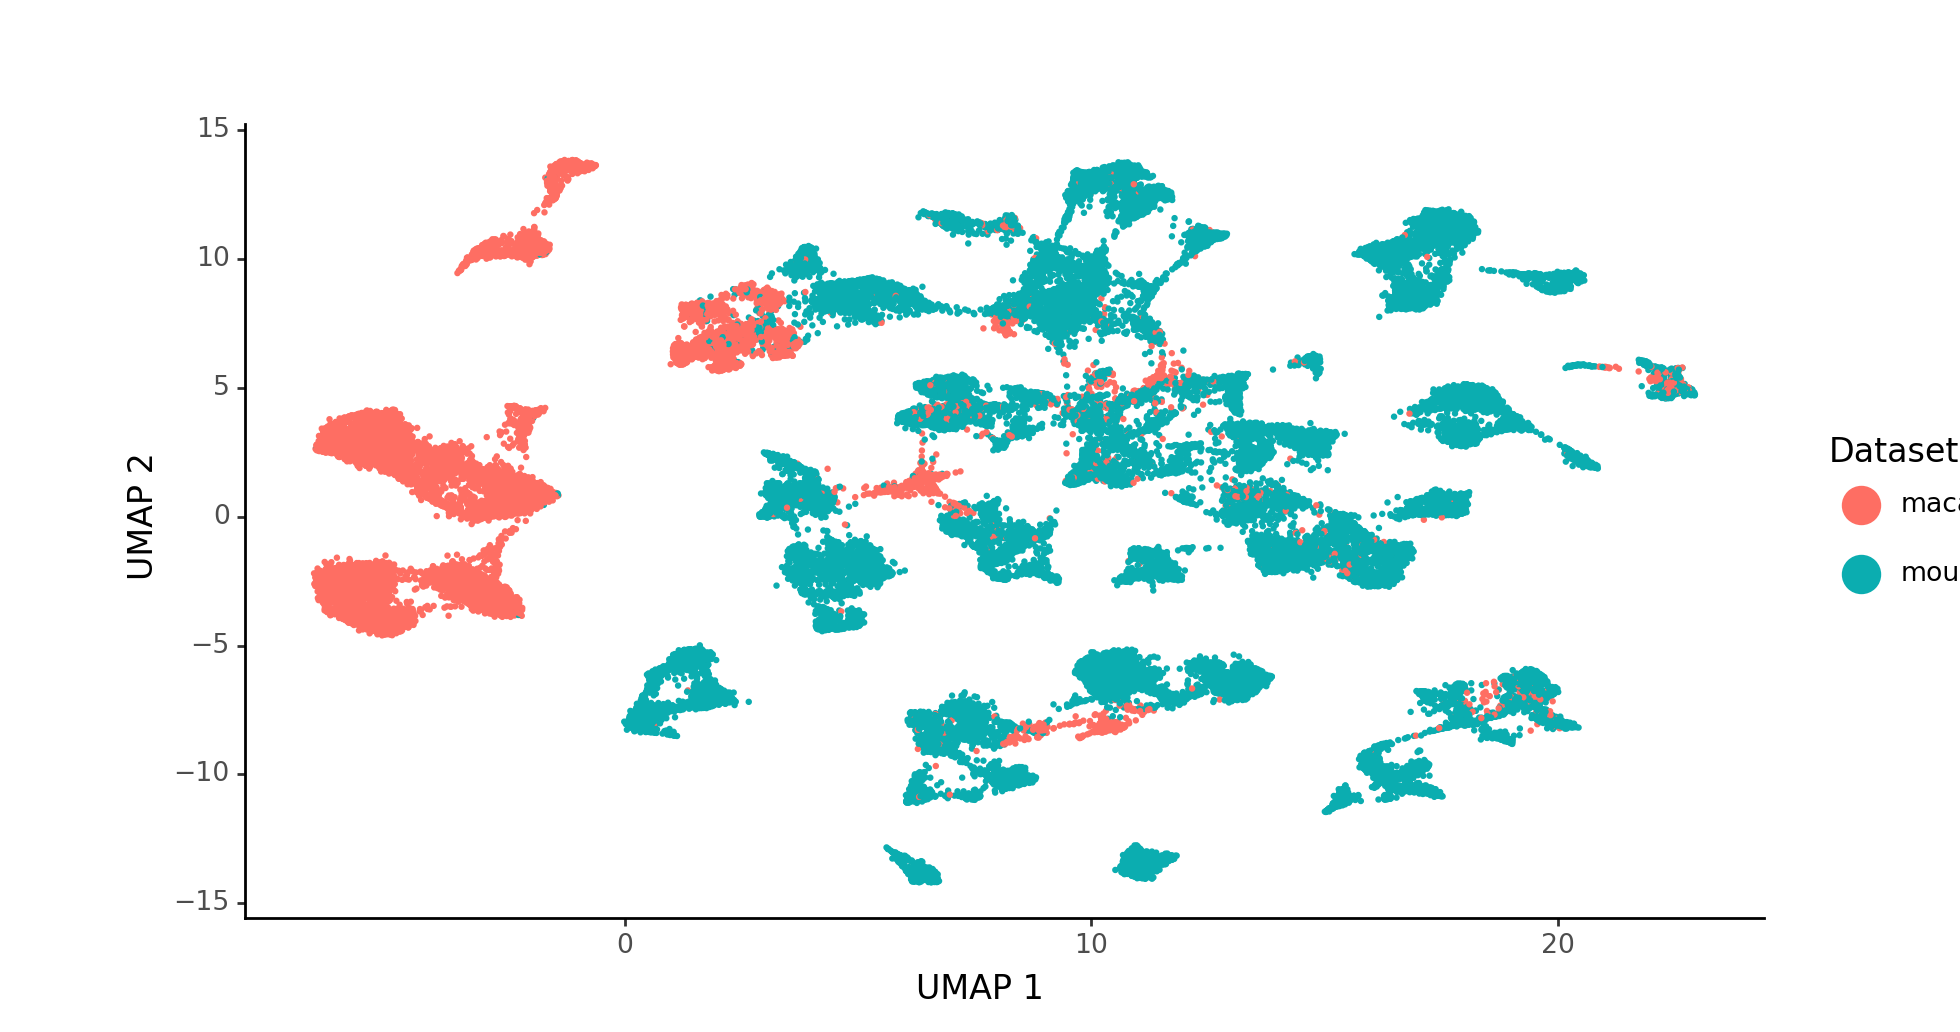

<IPython.core.display.Javascript object>


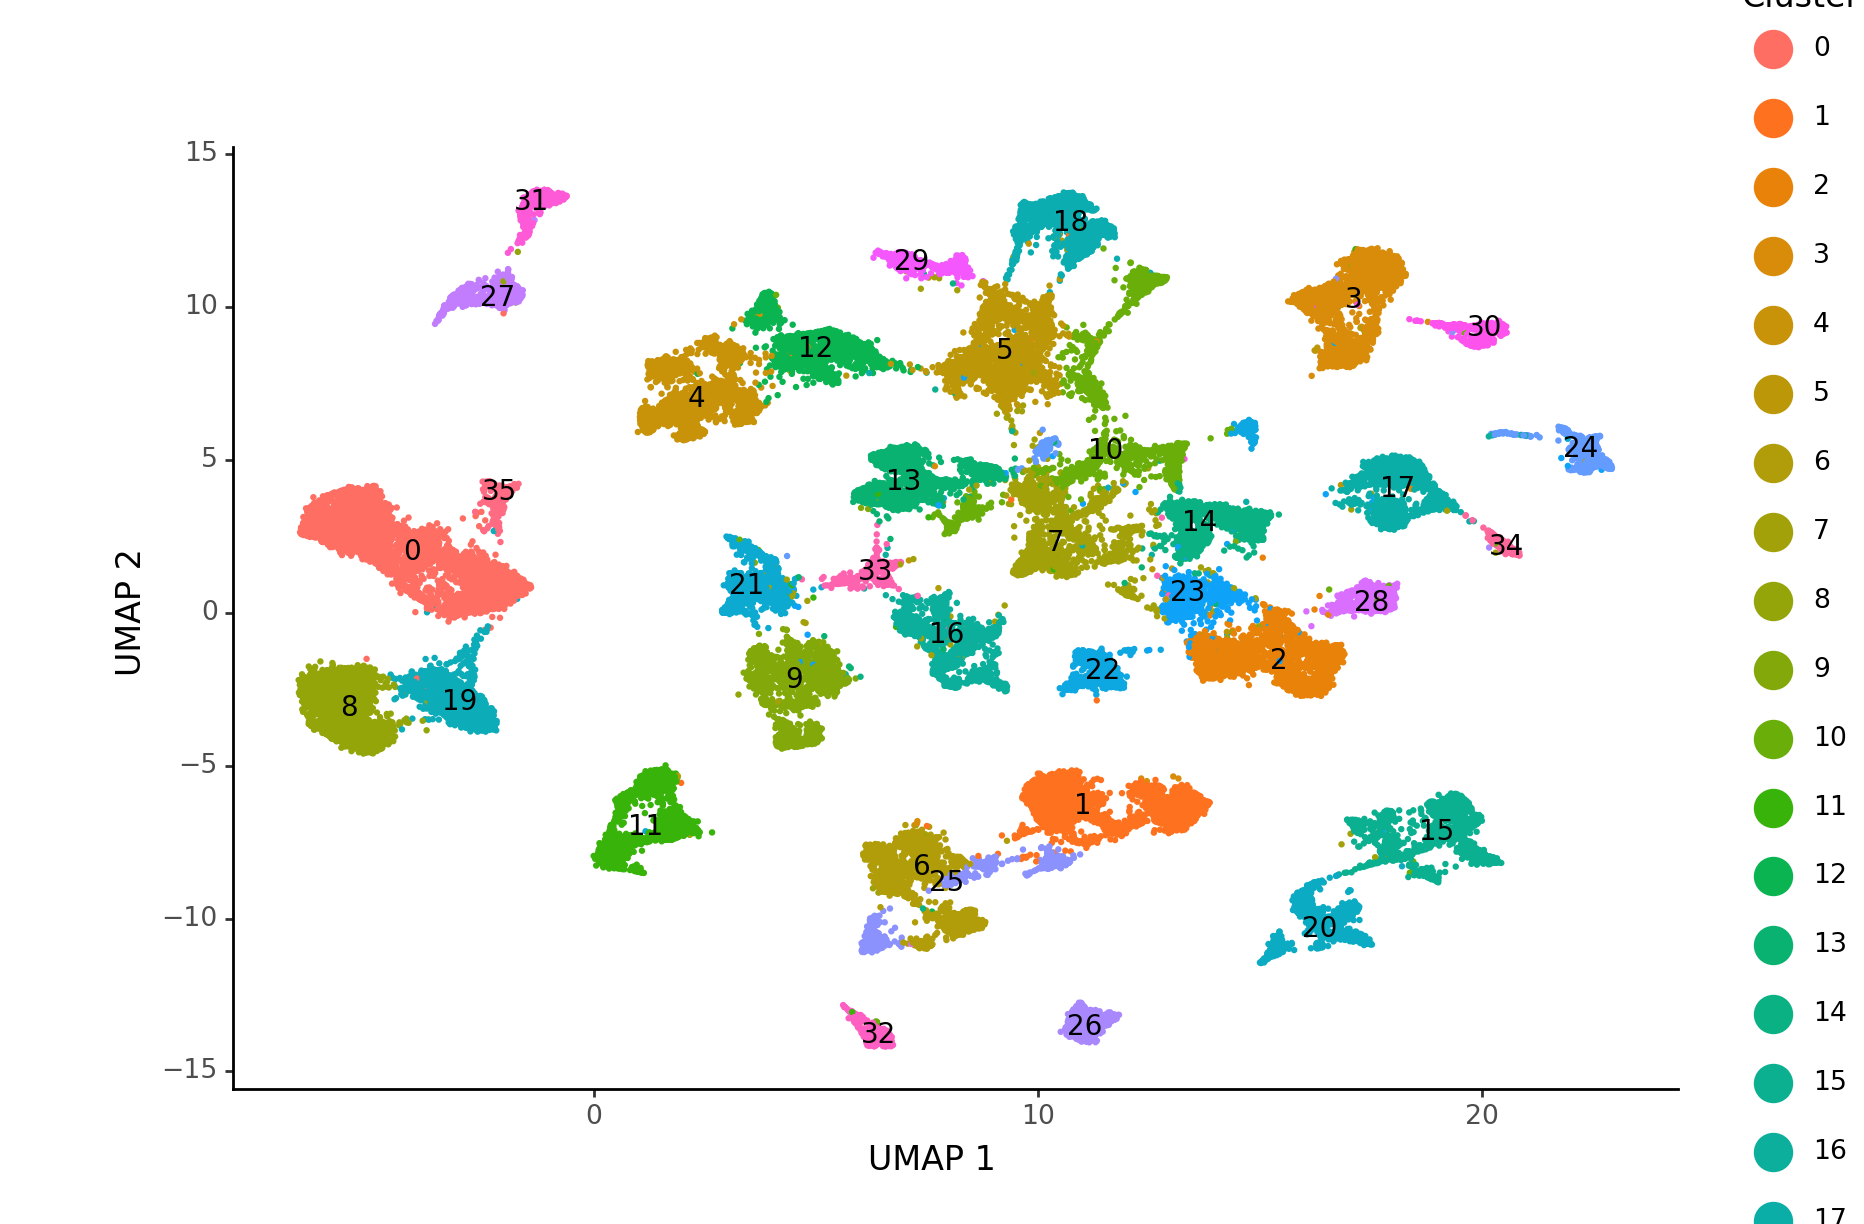

[<ggplot: (1192651114)>, <ggplot: (1219905970)>]

In [177]:
all_plots = pyliger.plot_by_dataset_and_cluster(ifnb_liger, axis_labels = ['UMAP 1', 'UMAP 2'], return_plots = True)
all_plots

<IPython.core.display.Javascript object>


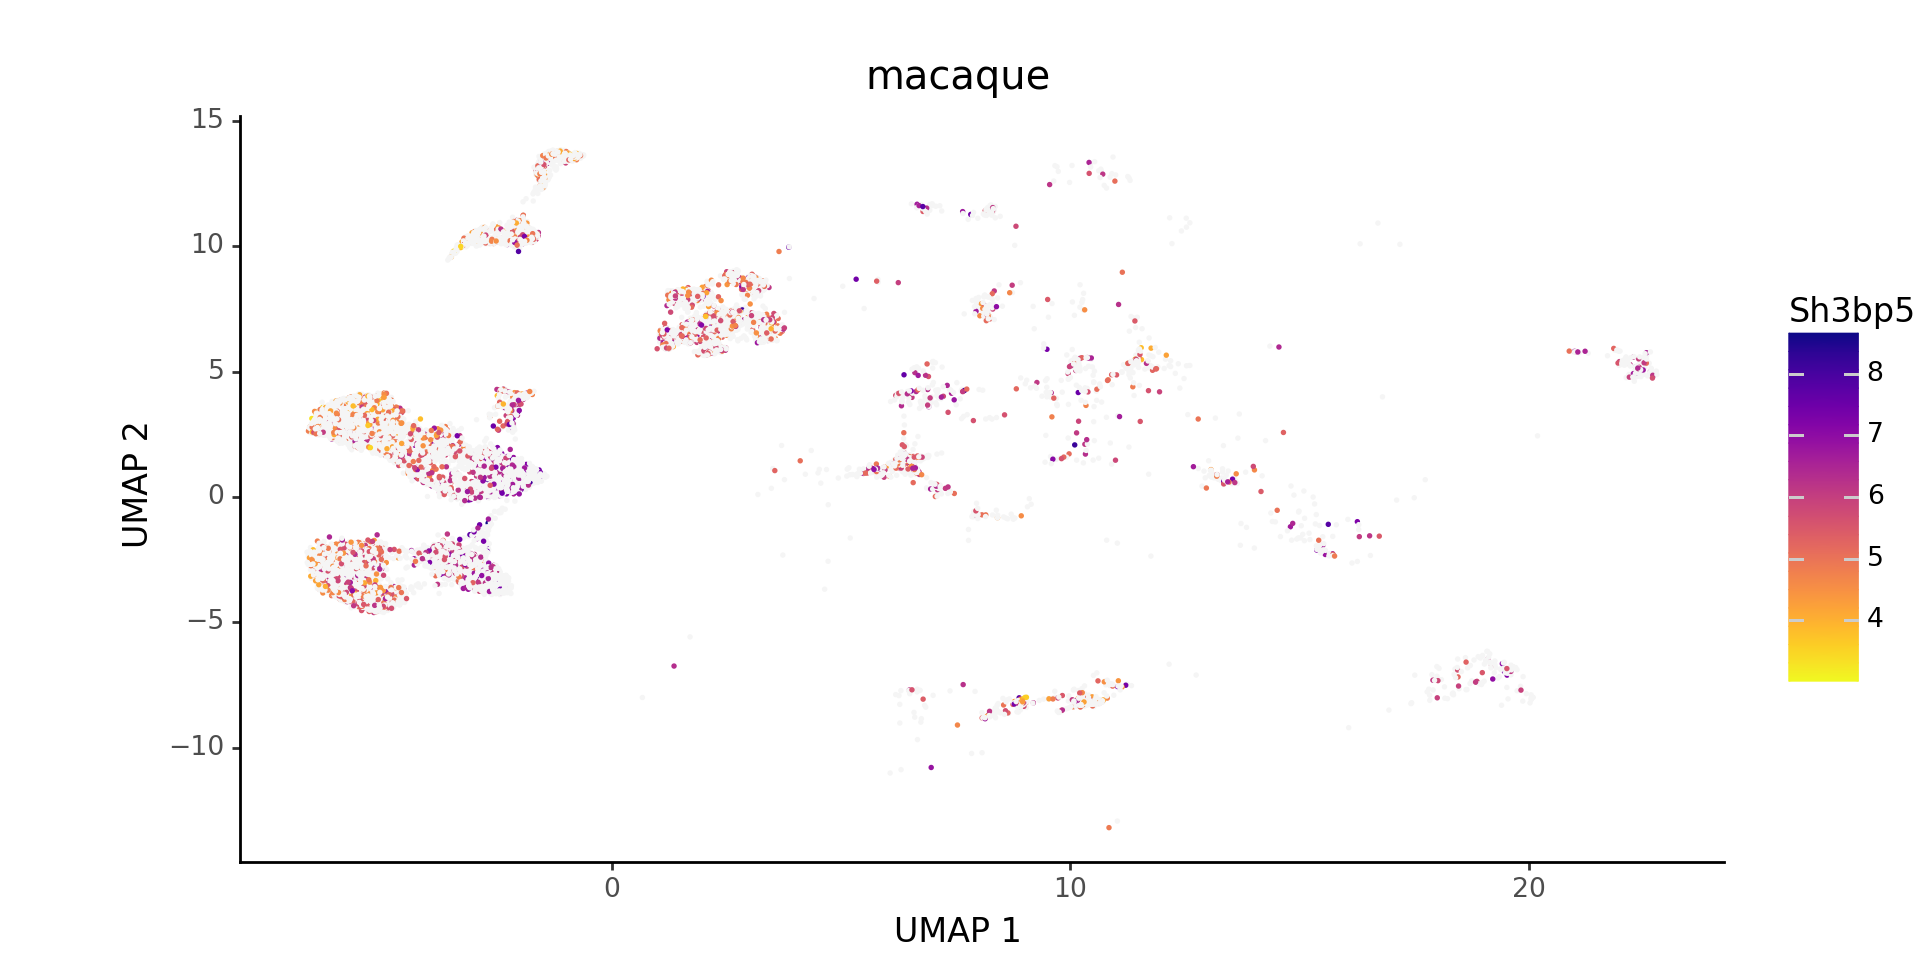

<IPython.core.display.Javascript object>


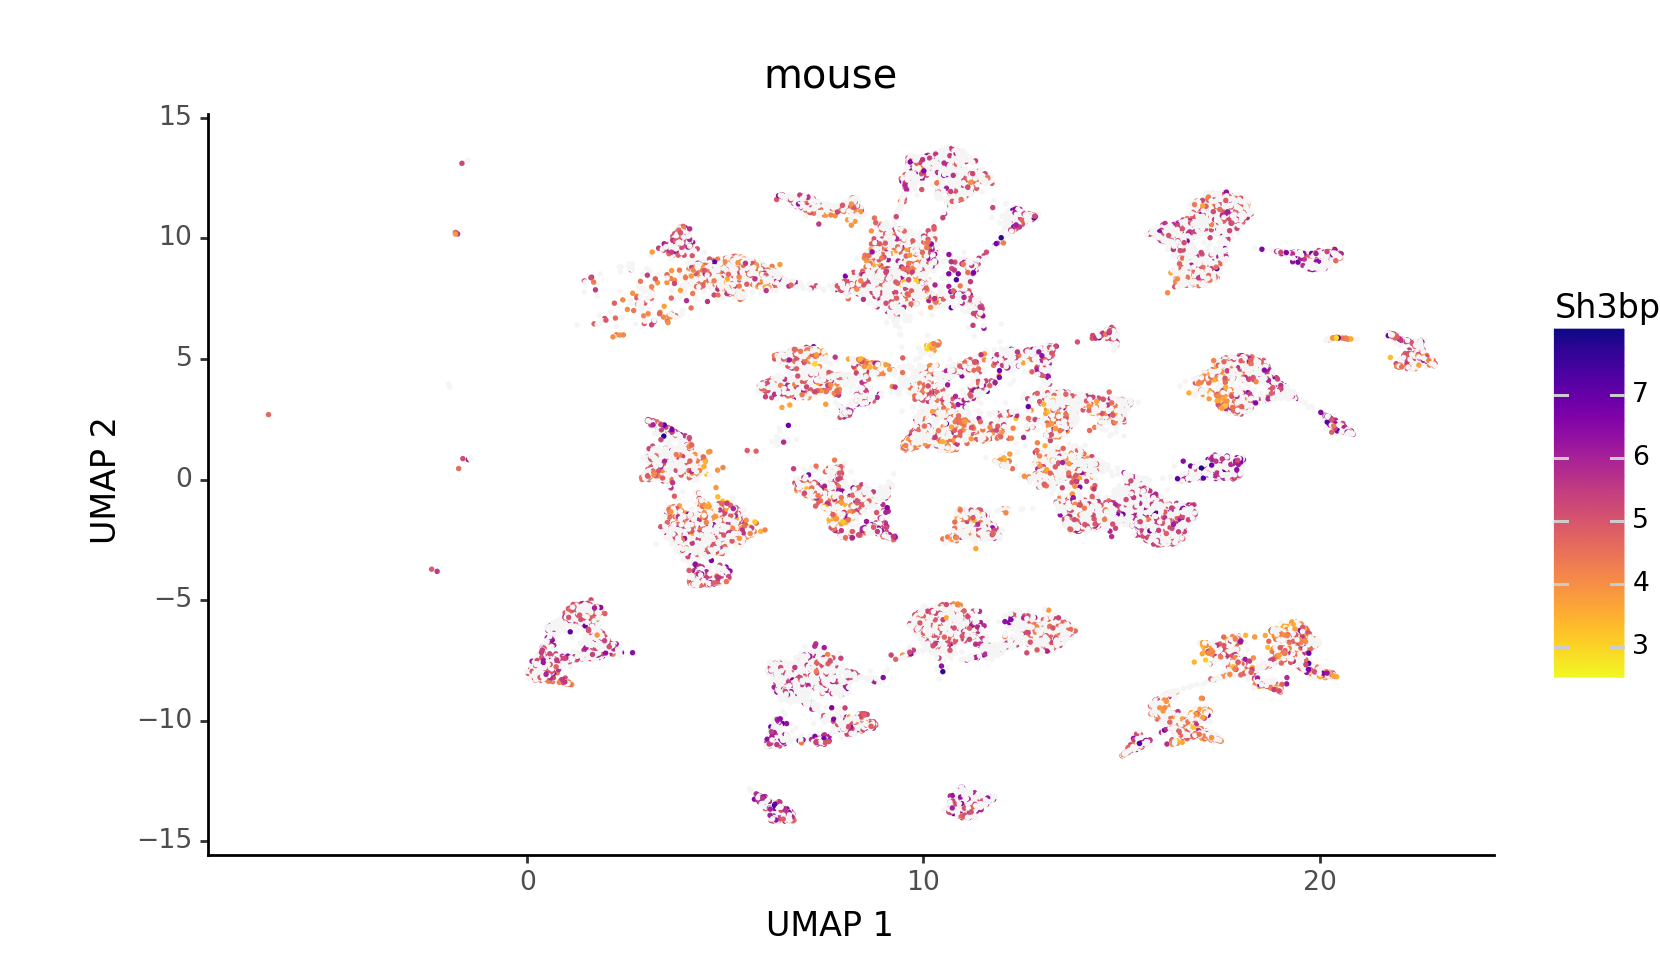

{'macaque': <ggplot: (1259341559)>, 'mouse': <ggplot: (1276038132)>}

In [179]:
PRF1 = pyliger.plot_gene(ifnb_liger, "Sh3bp5l", axis_labels = ['UMAP 1', 'UMAP 2'], return_plots = True)
PRF1

In [175]:
cluster_results = pyliger.run_wilcoxon(ifnb_liger, compare_method = "clusters")

Performing Wilcoxon test on ALL datasets: mouse, macaque


In [176]:
cluster_results

feature  group    avgExpr     logFC   statistic           pval  padj
0       Sh3bp5l    0.0 -19.381069 -3.641254  57066586.5  5.393948e-166   1.0
1         Tfb2m    0.0 -20.001214 -1.946017  55007418.5   8.158860e-06   1.0
2         Smyd3    0.0 -18.461837 -2.811397  48968572.5   1.411530e-24   1.0
3          Akt3    0.0 -13.050242  6.486698  53842230.5   1.661347e-01   1.0
4        Cep170    0.0 -14.246154 -1.884771  40760185.5   4.630311e-82   1.0
...         ...    ...        ...       ...         ...            ...   ...
384331    Mecp2   35.0 -14.532443  7.077651   5704516.0  1.794273e-129   1.0
384332  Slc10a3   35.0 -13.335860  5.401156   8181047.0   1.453752e-09   1.0
384333    Fam3a   35.0 -17.562035  3.905182   5093975.5   7.886862e-87   1.0
384334     Gab3   35.0 -22.969480 -4.025438   5627807.0   1.096504e-05   1.0
384335     Mpp1   35.0 -15.038569  5.710027   3592276.0   2.089026e-63   1.0

[384336 rows x 7 columns]

# CAME 

In [35]:
import came

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [36]:
data=came.load_example_data()

{'adatas': [AnnData object with n_obs × n_vars = 2142 × 20125
      obs: 'cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'dataset_name', 'donor', 'library', 'organ', 'organism', 'platform',
  AnnData object with n_obs × n_vars = 1886 × 14877
      obs: 'cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'dataset_name', 'donor', 'library', 'organ', 'organism', 'platform'],
 'varmap':       human.gene.name gene.name human.homology.type  \
 0              MT-ND1    mt-Nd1    ortholog_one2one   
 1              MT-ND2    mt-Nd2    ortholog_one2one   
 2              MT-CO1    mt-Co1    ortholog_one2one   
 3              MT-CO2    mt-Co2    ortholog_one2one   
 4             MT-ATP8   mt-Atp8    ortholog_one2one   
 ...               ...       ...                 ...   
 23773      AC012354.8   Gm27283    ortholog_one2one   
 23774      AC005722.2   Gm23663    ortholog_one2one   
 23775      SNORA15B-1   Snora15   ortholog_one2many   
 23776         SNORA15   Snora15   orthol

In [37]:
example_data_dict = came.load_example_data()
print(example_data_dict.keys())

dict_keys(['adatas', 'varmap', 'varmap_1v1', 'dataset_names', 'key_class'])


In [38]:
adatas = example_data_dict['adatas']
dsnames = example_data_dict['dataset_names']  # ('Baron_human', 'Baron_mouse')
df_varmap = example_data_dict['varmap']
df_varmap_1v1 = example_data_dict['varmap_1v1']
key_class1 = key_class2 = example_data_dict['key_class']

In [41]:
df_varmap

human.gene.name gene.name human.homology.type  \
0              MT-ND1    mt-Nd1    ortholog_one2one   
1              MT-ND2    mt-Nd2    ortholog_one2one   
2              MT-CO1    mt-Co1    ortholog_one2one   
3              MT-CO2    mt-Co2    ortholog_one2one   
4             MT-ATP8   mt-Atp8    ortholog_one2one   
...               ...       ...                 ...   
23773      AC012354.8   Gm27283    ortholog_one2one   
23774      AC005722.2   Gm23663    ortholog_one2one   
23775      SNORA15B-1   Snora15   ortholog_one2many   
23776         SNORA15   Snora15   ortholog_one2many   
23777      SNORA15B-2   Snora15   ortholog_one2many   

       human.gene.order.conservation.score  \
0                                     50.0   
1                                     75.0   
2                                    100.0   
3                                    100.0   
4                                    100.0   
...                                    ...   
23773                                  NaN   
23774                                  NaN   
23775                                  NaN   
23776                                  NaN   
23777                                  NaN   

       human.whole.genome.alignment.coverage  \
0                                      100.0   
1                                      100.0   
2                                      100.0   
3                                      100.0   
4                                      100.0   
...                                      ...   
23773                                    NaN   
23774                                    NaN   
23775                                    NaN   
23776                                    NaN   
23777                                    NaN   

       human.orthology.confidence..0.low..1.high.  
0                                               1  
1                                               1  
2                                               1  
3                                               1  
4                                               0  
...                                           ...  
23773                                           0  
23774                                           0  
23775                                           0  
23776                                           0  
23777                                           0  

[23778 rows x 6 columns]

In [72]:
adatas[0].obs

cell_ontology_class cell_ontology_id  \
index                                                                    
human3_lib4.final_cell_0810    type B pancreatic cell       CL:0000169   
human1_lib2.final_cell_0321    pancreatic ductal cell       CL:0002079   
human2_lib1.final_cell_0107    type B pancreatic cell       CL:0000169   
human2_lib3.final_cell_0340         pancreatic A cell       CL:0000171   
human1_lib3.final_cell_0389    type B pancreatic cell       CL:0000169   
...                                               ...              ...   
human3_lib3.final_cell_0482         pancreatic A cell       CL:0000171   
human4_lib3.final_cell_0416    pancreatic ductal cell       CL:0002079   
human2_lib1.final_cell_0119    type B pancreatic cell       CL:0000169   
human1_lib3.final_cell_0671          endothelial cell       CL:0000115   
human3_lib1.final_cell_0820  pancreatic stellate cell       CL:0002410   

                                     cell_type1 dataset_name   donor library  \
index                                                                          
human3_lib4.final_cell_0810                beta  Baron_human  human3    lib4   
human1_lib2.final_cell_0321              ductal  Baron_human  human1    lib2   
human2_lib1.final_cell_0107                beta  Baron_human  human2    lib1   
human2_lib3.final_cell_0340               alpha  Baron_human  human2    lib3   
human1_lib3.final_cell_0389                beta  Baron_human  human1    lib3   
...                                         ...          ...     ...     ...   
human3_lib3.final_cell_0482               alpha  Baron_human  human3    lib3   
human4_lib3.final_cell_0416              ductal  Baron_human  human4    lib3   
human2_lib1.final_cell_0119                beta  Baron_human  human2    lib1   
human1_lib3.final_cell_0671         endothelial  Baron_human  human1    lib3   
human3_lib1.final_cell_0820  activated_stellate  Baron_human  human3    lib1   

                                organ      organism platform  
index                                                         
human3_lib4.final_cell_0810  Pancreas  Homo sapiens   inDrop  
human1_lib2.final_cell_0321  Pancreas  Homo sapiens   inDrop  
human2_lib1.final_cell_0107  Pancreas  Homo sapiens   inDrop  
human2_lib3.final_cell_0340  Pancreas  Homo sapiens   inDrop  
human1_lib3.final_cell_0389  Pancreas  Homo sapiens   inDrop  
...                               ...           ...      ...  
human3_lib3.final_cell_0482  Pancreas  Homo sapiens   inDrop  
human4_lib3.final_cell_0416  Pancreas  Homo sapiens   inDrop  
human2_lib1.final_cell_0119  Pancreas  Homo sapiens   inDrop  
human1_lib3.final_cell_0671  Pancreas  Homo sapiens   inDrop  
human3_lib1.final_cell_0820  Pancreas  Homo sapiens   inDrop  

[2142 rows x 9 columns]

In [70]:
adatas[1].obs

cell_ontology_class cell_ontology_id  \
index                                                                    
mouse1_lib1.final_cell_0001    type B pancreatic cell       CL:0000169   
mouse1_lib1.final_cell_0002    pancreatic ductal cell       CL:0002079   
mouse1_lib1.final_cell_0003         pancreatic D cell       CL:0000173   
mouse1_lib1.final_cell_0004              Schwann cell       CL:0002573   
mouse1_lib1.final_cell_0005         pancreatic D cell       CL:0000173   
...                                               ...              ...   
mouse2_lib3.final_cell_0391    type B pancreatic cell       CL:0000169   
mouse2_lib3.final_cell_0392    type B pancreatic cell       CL:0000169   
mouse2_lib3.final_cell_0393    pancreatic ductal cell       CL:0002079   
mouse2_lib3.final_cell_0394  pancreatic stellate cell       CL:0002410   
mouse2_lib3.final_cell_0395    pancreatic ductal cell       CL:0002079   

                                     cell_type1 dataset_name   donor library  \
index                                                                          
mouse1_lib1.final_cell_0001                beta  Baron_mouse  mouse1    lib1   
mouse1_lib1.final_cell_0002              ductal  Baron_mouse  mouse1    lib1   
mouse1_lib1.final_cell_0003               delta  Baron_mouse  mouse1    lib1   
mouse1_lib1.final_cell_0004             schwann  Baron_mouse  mouse1    lib1   
mouse1_lib1.final_cell_0005               delta  Baron_mouse  mouse1    lib1   
...                                         ...          ...     ...     ...   
mouse2_lib3.final_cell_0391                beta  Baron_mouse  mouse2    lib3   
mouse2_lib3.final_cell_0392                beta  Baron_mouse  mouse2    lib3   
mouse2_lib3.final_cell_0393              ductal  Baron_mouse  mouse2    lib3   
mouse2_lib3.final_cell_0394  quiescent_stellate  Baron_mouse  mouse2    lib3   
mouse2_lib3.final_cell_0395              ductal  Baron_mouse  mouse2    lib3   

                                organ      organism platform  
index                                                         
mouse1_lib1.final_cell_0001  Pancreas  Mus musculus   inDrop  
mouse1_lib1.final_cell_0002  Pancreas  Mus musculus   inDrop  
mouse1_lib1.final_cell_0003  Pancreas  Mus musculus   inDrop  
mouse1_lib1.final_cell_0004  Pancreas  Mus musculus   inDrop  
mouse1_lib1.final_cell_0005  Pancreas  Mus musculus   inDrop  
...                               ...           ...      ...  
mouse2_lib3.final_cell_0391  Pancreas  Mus musculus   inDrop  
mouse2_lib3.final_cell_0392  Pancreas  Mus musculus   inDrop  
mouse2_lib3.final_cell_0393  Pancreas  Mus musculus   inDrop  
mouse2_lib3.final_cell_0394  Pancreas  Mus musculus   inDrop  
mouse2_lib3.final_cell_0395  Pancreas  Mus musculus   inDrop  

[1886 rows x 9 columns]

In [ ]:
dsnames = ('Mouse', 'Macaque')
dsn1, dsn2 = dsnames

path_rawdata1 = CAME_ROOT / 'came/sample_data/raw-Baron_human.h5ad'
path_rawdata2 = CAME_ROOT / 'came/sample_data/raw-Baron_mouse.h5ad'
path_varmap_1v1 = orthos.drop(columns='Gene stable ID')

Gene stable ID Gene name Mouse gene name  \
0      ENSMMUG00000000632   SH3BP5L         Sh3bp5l   
1      ENSMMUG00000038159     OR2W3         Olfr322   
2      ENSMMUG00000005570    TRIM58          Trim58   
3      ENSMMUG00000006214    OR11L1         Olfr323   
4      ENSMMUG00000022208    SCCPDH          Sccpdh   
...                   ...       ...             ...   
13703  ENSMMUG00000065379      ND4L         mt-Nd4l   
13704  ENSMMUG00000065387       ND4          mt-Nd4   
13705  ENSMMUG00000065354       ND5          mt-Nd5   
13706  ENSMMUG00000065359       ND6          mt-Nd6   
13707  ENSMMUG00000065382      CYTB         mt-Cytb   

       Mouse orthology confidence [0 low, 1 high]  
0                                               1  
1                                               1  
2                                               1  
3                                               1  
4                                               1  
...                                           ...  
13703                                           1  
13704                                           1  
13705                                           1  
13706                                           1  
13707                                           1  

[13708 rows x 4 columns]